In [1]:
import torch
import torchvision
from torchvision import datasets, transforms
import numpy as np
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import copy
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   

os.environ["CUDA_VISIBLE_DEVICES"]="0"

import matplotlib.pyplot as plt
import torch.optim as optim


In [2]:
local_epoch=1

In [3]:
torch.manual_seed(0)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [6]:

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
CIFAR_SGD_trainloader = torch.utils.data.DataLoader(trainset, batch_size=500,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=8)


Files already downloaded and verified
Files already downloaded and verified


In [7]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [8]:
# function to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #print(npimg)
    print(np.transpose(npimg, (1, 2, 0)).shape)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #plt.imshow(np.transpose(npimg))#, (1, 2, 0)))
    plt.show()

In [9]:
'''for i in range(5):
    tmp=trainset[i]
    fig=plt.figure
    plt.imshow(np.transpose(tmp[0],(1,2,0)))
    plt.show()
    print(classes[tmp[1]])'''

'for i in range(5):\n    tmp=trainset[i]\n    fig=plt.figure\n    plt.imshow(np.transpose(tmp[0],(1,2,0)))\n    plt.show()\n    print(classes[tmp[1]])'

In [10]:
'''# get some random training images
dataiter = iter(CIFAR_SGD_trainloader)
images, labels = dataiter.next()
print(images.shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
# print size of single image
print(images[1].shape)'''

"# get some random training images\ndataiter = iter(CIFAR_SGD_trainloader)\nimages, labels = dataiter.next()\nprint(images.shape)\n# show images\nimshow(torchvision.utils.make_grid(images))\n# print labels\nprint(' '.join('%5s' % classes[labels[j]] for j in range(4)))\n# print size of single image\nprint(images[1].shape)"

In [11]:
class DatasetSplit(Dataset):
    """An abstract Dataset class wrapped around Pytorch Dataset class.
    """

    def __init__(self, dataset, idxs):
        self.dataset = dataset
        self.idxs = [int(i) for i in idxs]

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, item):
        image, label = self.dataset[self.idxs[item]]
        return torch.tensor(image), torch.tensor(label)

In [12]:
def cifar_iid(dataset, num_users):
    """
    Sample I.I.D. client data from CIFAR10 dataset
    :param dataset:
    :param num_users:
    :return: dict of image index
    """
    num_items = int(len(dataset)/num_users)
    #num_items=8
    dict_users, all_idxs = {}, [i for i in range(len(dataset))]
    for i in range(num_users):
        dict_users[i] = set(np.random.choice(all_idxs, num_items, replace=False))
        all_idxs = list(set(all_idxs) - dict_users[i])
    return dict_users

In [13]:
'''cifar_iid_dataset=cifar_iid(trainset,2)
print(cifar_iid_dataset)'''

'cifar_iid_dataset=cifar_iid(trainset,2)\nprint(cifar_iid_dataset)'

In [14]:
'''num_clients=2
num_items=8

for x in range(num_clients):
    print(f"This is {x} client")
    index_list=list(cifar_iid_dataset[x])
    CIFAR_client_trainloader=DataLoader(DatasetSplit(trainset,index_list),batch_size=4,shuffle=False,num_workers=2)
    dataiter=iter(CIFAR_client_trainloader)
    for i in range(int(num_items/4)):
        images,labels=dataiter.next()
        print(images.shape)
        #print(trainset[index_list[i]])
        #print(image)
        fig=plt.figure
        imshow(torchvision.utils.make_grid(images))
        print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
        #print(classes[trainset[index_list[i]][1]])'''

'num_clients=2\nnum_items=8\n\nfor x in range(num_clients):\n    print(f"This is {x} client")\n    index_list=list(cifar_iid_dataset[x])\n    CIFAR_client_trainloader=DataLoader(DatasetSplit(trainset,index_list),batch_size=4,shuffle=False,num_workers=2)\n    dataiter=iter(CIFAR_client_trainloader)\n    for i in range(int(num_items/4)):\n        images,labels=dataiter.next()\n        print(images.shape)\n        #print(trainset[index_list[i]])\n        #print(image)\n        fig=plt.figure\n        imshow(torchvision.utils.make_grid(images))\n        print(\' \'.join(\'%5s\' % classes[labels[j]] for j in range(4)))\n        #print(classes[trainset[index_list[i]][1]])'

In [15]:
'''num_clients=2
num_items=5

for x in range(num_clients):
    print(f"This is {x} client")
    index_list=list(cifar_iid_dataset[x])
    for i in range(num_items):
        image=trainset[index_list[i]][0]
        #print(trainset[index_list[i]])
        #print(image)
        fig=plt.figure
        plt.imshow(np.transpose(image,(1,2,0)))
        plt.show()
        print(classes[trainset[index_list[i]][1]])'''

'num_clients=2\nnum_items=5\n\nfor x in range(num_clients):\n    print(f"This is {x} client")\n    index_list=list(cifar_iid_dataset[x])\n    for i in range(num_items):\n        image=trainset[index_list[i]][0]\n        #print(trainset[index_list[i]])\n        #print(image)\n        fig=plt.figure\n        plt.imshow(np.transpose(image,(1,2,0)))\n        plt.show()\n        print(classes[trainset[index_list[i]][1]])'

In [16]:
def cifar_noniid(dataset, num_users,class_per_user=1):
    """
    Sample non-I.I.D client data from CIFAR10 dataset
    :param dataset:
    :param num_users:
    :return:
    """
    #num_shards, num_imgs = 200, 250
    #num_shards, num_imgs = 200, 250
    class_per_user=class_per_user
    num_shards=num_users*class_per_user
    num_imgs=int(len(dataset)/num_shards)
    idx_shard = [i for i in range(num_shards)]
    dict_users = {i: np.array([],dtype='int64') for i in range(num_users)}
    idxs = np.arange(num_shards*num_imgs)
    # labels = dataset.train_labels.numpy()
    #labels = np.array(dataset.train_labels)

    labels=[]
    for element in dataset:
        labels.append(int(element[1]))
    #print(type(labels[0]))
    labels=np.array(labels)
    #labels=labels.astype('int64')
    # sort labels
    
    idxs_labels = np.vstack((idxs, labels))
    idxs_labels = idxs_labels[:, idxs_labels[1, :].argsort()]
    idxs = idxs_labels[0, :]

    # divide and assign
    for i in range(num_users):
        rand_set = set(np.random.choice(idx_shard, class_per_user, replace=False))
        idx_shard = list(set(idx_shard) - rand_set)
        for rand in rand_set:
            dict_users[i] = np.concatenate(
                (dict_users[i], idxs[rand*num_imgs:(rand+1)*num_imgs]), axis=0)
    return dict_users

In [17]:
'''cifar_noniid_dataset=cifar_noniid(trainset,2)
print(cifar_noniid_dataset)'''

'cifar_noniid_dataset=cifar_noniid(trainset,2)\nprint(cifar_noniid_dataset)'

In [18]:
'''num_clients=2
num_items=250*2

for x in range(num_clients):
    print(f"This is {x} client")
    index_list=list(cifar_noniid_dataset[x])
    CIFAR_client_trainloader=DataLoader(DatasetSplit(trainset,index_list),batch_size=4,shuffle=False,num_workers=2)
    dataiter=iter(CIFAR_client_trainloader)
    for i in range(int(num_items/4)):
        images,labels=dataiter.next()
        print(images.shape)
        #print(trainset[index_list[i]])
        #print(image)
        fig=plt.figure
        imshow(torchvision.utils.make_grid(images))
        print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
        #print(classes[trainset[index_list[i]][1]])'''

'num_clients=2\nnum_items=250*2\n\nfor x in range(num_clients):\n    print(f"This is {x} client")\n    index_list=list(cifar_noniid_dataset[x])\n    CIFAR_client_trainloader=DataLoader(DatasetSplit(trainset,index_list),batch_size=4,shuffle=False,num_workers=2)\n    dataiter=iter(CIFAR_client_trainloader)\n    for i in range(int(num_items/4)):\n        images,labels=dataiter.next()\n        print(images.shape)\n        #print(trainset[index_list[i]])\n        #print(image)\n        fig=plt.figure\n        imshow(torchvision.utils.make_grid(images))\n        print(\' \'.join(\'%5s\' % classes[labels[j]] for j in range(4)))\n        #print(classes[trainset[index_list[i]][1]])'

In [19]:
'''num_clients=2
num_items=5
num_imgs=250
cifar_noniid_dataset=cifar_noniid(trainset, num_clients)
#print(cifar_noniid_dataset)
for x in range(num_clients):
    print(f"This is {x} client")
    index_list=list(cifar_noniid_dataset[x])
    #print(index_list)
    #print(index_list[0])
    #print(type(index_list[0]))
    for y in range(2):
        for i in range(num_items):
            image=trainset[index_list[i+num_imgs*y]][0]
            #print(image)
            fig=plt.figure
            plt.imshow(np.transpose(image,(1,2,0)))
            plt.show()
            print(classes[trainset[index_list[i+num_imgs*y]][1]])'''

'num_clients=2\nnum_items=5\nnum_imgs=250\ncifar_noniid_dataset=cifar_noniid(trainset, num_clients)\n#print(cifar_noniid_dataset)\nfor x in range(num_clients):\n    print(f"This is {x} client")\n    index_list=list(cifar_noniid_dataset[x])\n    #print(index_list)\n    #print(index_list[0])\n    #print(type(index_list[0]))\n    for y in range(2):\n        for i in range(num_items):\n            image=trainset[index_list[i+num_imgs*y]][0]\n            #print(image)\n            fig=plt.figure\n            plt.imshow(np.transpose(image,(1,2,0)))\n            plt.show()\n            print(classes[trainset[index_list[i+num_imgs*y]][1]])'

In [20]:
def Quantize(input):
    result=torch.sign(input)
    return result

아직 이름만 signSGD이지 일반적인 SGD와 같을 때

In [21]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(64 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)
        #self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = (F.relu(self.conv3(x)))
        x = x.view(-1, 64*4*4)
        x = F.relu(self.fc1(x))
        x = (self.fc2(x))
        
        return x

In [22]:
def get_from_absmomentum(momentum,func):
    save=0
    if func==max:
        save=-float('inf')
    if func==min:
        save=float('inf')
    numel=0
    for el in momentum:
        el=abs(el)
        if func=='mean':
            save+=el.sum()
            numel+=el.numel()
        if func==max:
            save=save if save>el.max() else el.max()
        if func==min:
            save=save if save<el.min() else el.min()

    if func=='mean':
        save/=numel
    
    
    return save
    

signSGD Federated learning

In [23]:
def error_send(momentum,p_t,cut):
    boundary_low=cut*0.7
    boundary_high=cut*1.3
    abs_moment=abs(momentum)
    result=p_t*((abs_moment<boundary_low)|(abs_moment>boundary_high))
    return result
    

In [24]:
import torch
from torch.optim import Optimizer#, required


class signSGD(Optimizer):
    r"""Implements stochastic gradient descent (optionally with momentum).

    Nesterov momentum is based on the formula from
    `On the importance of initialization and momentum in deep learning`__.

    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float): learning rate
        momentum (float, optional): momentum factor (default: 0)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        dampening (float, optional): dampening for momentum (default: 0)
        nesterov (bool, optional): enables Nesterov momentum (default: False)

    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> optimizer.zero_grad()
        >>> loss_fn(model(input), target).backward()
        >>> optimizer.step()

    __ http://www.cs.toronto.edu/%7Ehinton/absps/momentum.pdf

    .. note::
        The implementation of SGD with Momentum/Nesterov subtly differs from
        Sutskever et. al. and implementations in some other frameworks.

        Considering the specific case of Momentum, the update can be written as

        .. math::
            \begin{aligned}
                v_{t+1} & = \mu * v_{t} + g_{t+1}, \\
                p_{t+1} & = p_{t} - \text{lr} * v_{t+1},
            \end{aligned}

        where :math:`p`, :math:`g`, :math:`v` and :math:`\mu` denote the 
        parameters, gradient, velocity, and momentum respectively.

        This is in contrast to Sutskever et. al. and
        other frameworks which employ an update of the form

        .. math::
            \begin{aligned}
                v_{t+1} & = \mu * v_{t} + \text{lr} * g_{t+1}, \\
                p_{t+1} & = p_{t} - v_{t+1}.
            \end{aligned}

        The Nesterov version is analogously modified.
    """

    def __init__(self, params, lr=-1, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False,error=[]):
        #if lr is not required and lr < 0.0:
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(signSGD, self).__init__(params, defaults)
        self.error=error
        self.num_of_step=0

    def __setstate__(self, state):
        super(signSGD, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)

    @torch.no_grad()
    def step(self,On=True,cut=0.0007, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        #print(self.param_groups)
        gradient=[]
        first=1
        
        for group in self.param_groups:
            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad
                
                if weight_decay != 0:
                    d_p = d_p.add(p, alpha=weight_decay)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                    else:
                        buf = param_state['momentum_buffer']
                        if On==True:
                            d_p=error_send(momentum=buf,p_t=d_p,cut=cut)
                        
                            
                        buf.mul_(momentum).add_(d_p, alpha=1 - dampening)
                    '''if nesterov:
                        d_p = d_p.add(buf, alpha=momentum)
                    else:
                        d_p = buf'''

                p.add_(d_p, alpha=-group['lr'])

        return loss
    @torch.no_grad()
    def get_momentum(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        #print(self.param_groups)
        momentum=[]
        for group in self.param_groups:

            

            for p in group['params']:
                param_state = self.state[p]
                momentum.append(param_state['momentum_buffer'])
        return (momentum)
    
    @torch.no_grad()
    def get_quantized_momentum(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()
        #print(self.param_groups)
        momentum=[]
        for group in self.param_groups:

            

            for p in group['params']:
                param_state = self.state[p]
                momentum.append(torch.sign(param_state['momentum_buffer']))
        return (momentum)

In [25]:
def get_quantizationLoss(gradient,lr):
    total=0
    for layer_grad in gradient:
        
        quantized_layer_grad=torch.sign(layer_grad)*lr
        layer_quantize_loss=(abs(layer_grad-quantized_layer_grad)).sum()
        total+=layer_quantize_loss
    return total
    

In [26]:
class LocalUpdate(object):
    def __init__(self,lr,local_epoch,device,batch_size, dataset=None, idxs=None):
        self.lr=lr
        self.local_epoch=local_epoch
        self.device=device
        self.loss_func = nn.CrossEntropyLoss()
        self.selected_clients = []
        self.ldr_train = DataLoader(DatasetSplit(dataset, idxs), batch_size=batch_size, shuffle=True)
        self.iterate=0
        self.error=[]
        self.cut_epoch=int(0.6*self.local_epoch)

    def train(self,net,On=True):
        net.train()
        # train and update
        optimizer=signSGD(net.parameters(), lr=0.1,error=self.error,momentum=1)
        #print(f"On:{On}")
        epoch_loss = []
        for iter in range(self.local_epoch):
            if iter<self.cut_epoch:
                this_on=False
                cut=self.lr
            if iter==self.cut_epoch:
                this_on=On

                cut=self.lr
                
                
            batch_loss = []
            
            
            #print(this_on,cut)
            
            for batch_idx, (images, labels) in enumerate(self.ldr_train):
                images, labels = images.to(self.device), labels.to(self.device)
                net.zero_grad()
                log_probs = net(images)
                loss = self.loss_func(log_probs, labels)
                loss.backward()
                optimizer.step(On=this_on,cut=cut)
                batch_loss.append(loss.item())
            epoch_loss.append(sum(batch_loss)/len(batch_loss))
        this_momentum=optimizer.get_momentum()
        cut=get_from_absmomentum(this_momentum,'mean')
        momentum=optimizer.get_quantized_momentum()
        return momentum, sum(epoch_loss) / len(epoch_loss),cut

In [27]:
def list_add(a,b,c):
    result=[]
    for i in range(len(a)):
        result.append(a[i]+b[i]*c)
    return result

cifar10 FedAvg iid로 학습

In [28]:
device=torch.device('cuda')
FedAvg_model=Net().cuda()
criterion= nn.CrossEntropyLoss().to(device)
FedAvg_model.train()
epoch_loss = []

# Set optimizer for the local updates

optimizer = torch.optim.SGD(FedAvg_model.parameters(), lr=0.001,
                                momentum=0.9)
global_epoch=5001

In [29]:
weight_saved=FedAvg_model.state_dict()

In [30]:
C=0.1
num_clients=100
#CIFAR_noniid_dataset=cifar_noniid(trainset, num_clients)
CIFAR_iid_dataset=cifar_iid(trainset, num_clients)
loss_train = []
acc_train=[]

맨 처음에 local gradient sign이 0인 경우가 있는 것 같다(진짜로 0이어서 그것의 sign도 0이 나오는 경우...)

In [31]:
#low boundary 안에 있는 녀석들만 update했을 때
learning_rate=0.0007
for epoch in range(global_epoch):

    #m=max(int(C*num_clients),1)
    m=5
    print(f"This is global {epoch} epoch")
    selected_user=np.random.choice(range(num_clients),m,replace=False)
    first=1
    local_setting=[]
    for repeat in range(1):
        local_gradient=[]
        local_loss=[]
        local_cut=[]
        
        for idx,user in enumerate(selected_user):
            #print(f"client :{idx}")
            if first==1:
                #local_setting.append(LocalUpdate(lr=0.0007,local_epoch=50,device=device,batch_size=40,dataset=trainset, idxs=CIFAR_iid_dataset[user]))
                local_setting.append(LocalUpdate(lr=learning_rate,local_epoch=local_epoch,device=device,batch_size=40,dataset=trainset, idxs=CIFAR_iid_dataset[user]))
                this_local_setting=local_setting[-1]
            else:
                this_local_setting=local_setting[idx]
            gradient,loss,cut=this_local_setting.train(net=copy.deepcopy(FedAvg_model).to(device),On=False)

            local_gradient.append(copy.deepcopy(gradient))
            #print(local_weight[0].keys())
            local_loss.append(copy.deepcopy(loss))
            local_cut.append(copy.deepcopy(cut))
        #print("Local_gradient")
        #print(local_gradient)
        first=0
        FedAvg_gradient=copy.deepcopy(local_gradient[0])
        for i in range(len(FedAvg_gradient)):
            FedAvg_gradient[i]*=local_cut[0]
        #print(local_gradient)
        #for key in FedAvg_weight.keys():
        for i in range(1,len(local_gradient)):
            FedAvg_gradient=list_add(FedAvg_gradient,local_gradient[i],local_cut[i])
            #print(i)
            #print(FedAvg_gradient[0])
        #print("FedAvg_gradient")
        #print(FedAvg_gradient)
        temp=FedAvg_model.state_dict()
        for idx,key in enumerate(temp.keys()):
            #print(key)
            #print(temp[key].size())
            #print(FedAvg_gradient[idx].size())
            #print(torch.sign(FedAvg_gradient[idx]))
            #print(torch.sign(FedAvg_gradient[idx])*learning_rate)
            temp[key]+=-learning_rate*torch.sign(FedAvg_gradient[idx])
            #print(temp[key])
        FedAvg_model.load_state_dict(temp)
    first=1
    loss_avg = sum(local_loss) / len(local_loss)
    print(' Average loss {:.3f}'.format( loss_avg))
    loss_train.append(loss_avg)
    if epoch%1==0:
        for j in range(1):
            FedAvg_model.eval()         
            correct = 0
            total = 0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data[0].to(device), data[1].to(device)
                    outputs = FedAvg_model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %f %%' % (
                100 * correct / float(total)))
        acc_train.append(100 * correct / float(total))
 
    FedAvg_model.train()

This is global 0 epoch


/home/dana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


 Average loss 2.307
Accuracy of the network on the 10000 test images: 11.430000 %
This is global 1 epoch
 Average loss 2.296
Accuracy of the network on the 10000 test images: 10.130000 %
This is global 2 epoch
 Average loss 2.285
Accuracy of the network on the 10000 test images: 12.190000 %
This is global 3 epoch
 Average loss 2.260
Accuracy of the network on the 10000 test images: 16.720000 %
This is global 4 epoch
 Average loss 2.242
Accuracy of the network on the 10000 test images: 16.640000 %
This is global 5 epoch
 Average loss 2.202
Accuracy of the network on the 10000 test images: 16.850000 %
This is global 6 epoch
 Average loss 2.175
Accuracy of the network on the 10000 test images: 17.230000 %
This is global 7 epoch
 Average loss 2.160
Accuracy of the network on the 10000 test images: 18.590000 %
This is global 8 epoch
 Average loss 2.131
Accuracy of the network on the 10000 test images: 22.480000 %
This is global 9 epoch
 Average loss 2.133
Accuracy of the network on the 1000

 Average loss 1.588
Accuracy of the network on the 10000 test images: 47.110000 %
This is global 79 epoch
 Average loss 1.576
Accuracy of the network on the 10000 test images: 47.240000 %
This is global 80 epoch
 Average loss 1.544
Accuracy of the network on the 10000 test images: 47.800000 %
This is global 81 epoch
 Average loss 1.579
Accuracy of the network on the 10000 test images: 47.720000 %
This is global 82 epoch
 Average loss 1.544
Accuracy of the network on the 10000 test images: 47.840000 %
This is global 83 epoch
 Average loss 1.513
Accuracy of the network on the 10000 test images: 48.290000 %
This is global 84 epoch
 Average loss 1.534
Accuracy of the network on the 10000 test images: 48.620000 %
This is global 85 epoch
 Average loss 1.508
Accuracy of the network on the 10000 test images: 48.910000 %
This is global 86 epoch
 Average loss 1.545
Accuracy of the network on the 10000 test images: 48.820000 %
This is global 87 epoch
 Average loss 1.528
Accuracy of the network on

 Average loss 1.343
Accuracy of the network on the 10000 test images: 55.950000 %
This is global 156 epoch
 Average loss 1.314
Accuracy of the network on the 10000 test images: 56.030000 %
This is global 157 epoch
 Average loss 1.331
Accuracy of the network on the 10000 test images: 56.340000 %
This is global 158 epoch
 Average loss 1.350
Accuracy of the network on the 10000 test images: 56.190000 %
This is global 159 epoch
 Average loss 1.325
Accuracy of the network on the 10000 test images: 56.160000 %
This is global 160 epoch
 Average loss 1.368
Accuracy of the network on the 10000 test images: 56.290000 %
This is global 161 epoch
 Average loss 1.306
Accuracy of the network on the 10000 test images: 56.460000 %
This is global 162 epoch
 Average loss 1.348
Accuracy of the network on the 10000 test images: 56.500000 %
This is global 163 epoch
 Average loss 1.315
Accuracy of the network on the 10000 test images: 55.990000 %
This is global 164 epoch
 Average loss 1.298
Accuracy of the n

 Average loss 1.251
Accuracy of the network on the 10000 test images: 59.440000 %
This is global 233 epoch
 Average loss 1.190
Accuracy of the network on the 10000 test images: 59.830000 %
This is global 234 epoch
 Average loss 1.199
Accuracy of the network on the 10000 test images: 60.020000 %
This is global 235 epoch
 Average loss 1.185
Accuracy of the network on the 10000 test images: 60.300000 %
This is global 236 epoch
 Average loss 1.195
Accuracy of the network on the 10000 test images: 59.800000 %
This is global 237 epoch
 Average loss 1.177
Accuracy of the network on the 10000 test images: 60.170000 %
This is global 238 epoch
 Average loss 1.206
Accuracy of the network on the 10000 test images: 59.950000 %
This is global 239 epoch
 Average loss 1.187
Accuracy of the network on the 10000 test images: 60.290000 %
This is global 240 epoch
 Average loss 1.147
Accuracy of the network on the 10000 test images: 60.100000 %
This is global 241 epoch
 Average loss 1.177
Accuracy of the n

 Average loss 1.094
Accuracy of the network on the 10000 test images: 63.150000 %
This is global 310 epoch
 Average loss 1.070
Accuracy of the network on the 10000 test images: 63.050000 %
This is global 311 epoch
 Average loss 1.055
Accuracy of the network on the 10000 test images: 62.660000 %
This is global 312 epoch
 Average loss 1.050
Accuracy of the network on the 10000 test images: 63.170000 %
This is global 313 epoch
 Average loss 1.069
Accuracy of the network on the 10000 test images: 62.950000 %
This is global 314 epoch
 Average loss 1.129
Accuracy of the network on the 10000 test images: 63.130000 %
This is global 315 epoch
 Average loss 1.058
Accuracy of the network on the 10000 test images: 63.310000 %
This is global 316 epoch
 Average loss 1.033
Accuracy of the network on the 10000 test images: 63.490000 %
This is global 317 epoch
 Average loss 1.060
Accuracy of the network on the 10000 test images: 63.320000 %
This is global 318 epoch
 Average loss 1.056
Accuracy of the n

 Average loss 0.968
Accuracy of the network on the 10000 test images: 65.410000 %
This is global 387 epoch
 Average loss 0.963
Accuracy of the network on the 10000 test images: 65.120000 %
This is global 388 epoch
 Average loss 0.963
Accuracy of the network on the 10000 test images: 65.420000 %
This is global 389 epoch
 Average loss 0.998
Accuracy of the network on the 10000 test images: 65.490000 %
This is global 390 epoch
 Average loss 0.976
Accuracy of the network on the 10000 test images: 65.570000 %
This is global 391 epoch
 Average loss 0.998
Accuracy of the network on the 10000 test images: 65.420000 %
This is global 392 epoch
 Average loss 0.972
Accuracy of the network on the 10000 test images: 65.500000 %
This is global 393 epoch
 Average loss 0.995
Accuracy of the network on the 10000 test images: 65.490000 %
This is global 394 epoch
 Average loss 1.022
Accuracy of the network on the 10000 test images: 65.560000 %
This is global 395 epoch
 Average loss 0.925
Accuracy of the n

 Average loss 0.969
Accuracy of the network on the 10000 test images: 66.600000 %
This is global 464 epoch
 Average loss 0.900
Accuracy of the network on the 10000 test images: 66.280000 %
This is global 465 epoch
 Average loss 0.913
Accuracy of the network on the 10000 test images: 66.570000 %
This is global 466 epoch
 Average loss 0.933
Accuracy of the network on the 10000 test images: 66.630000 %
This is global 467 epoch
 Average loss 0.943
Accuracy of the network on the 10000 test images: 66.700000 %
This is global 468 epoch
 Average loss 0.877
Accuracy of the network on the 10000 test images: 66.610000 %
This is global 469 epoch
 Average loss 0.889
Accuracy of the network on the 10000 test images: 66.600000 %
This is global 470 epoch
 Average loss 0.916
Accuracy of the network on the 10000 test images: 67.110000 %
This is global 471 epoch
 Average loss 0.910
Accuracy of the network on the 10000 test images: 66.970000 %
This is global 472 epoch
 Average loss 0.878
Accuracy of the n

 Average loss 0.817
Accuracy of the network on the 10000 test images: 68.110000 %
This is global 541 epoch
 Average loss 0.829
Accuracy of the network on the 10000 test images: 68.170000 %
This is global 542 epoch
 Average loss 0.855
Accuracy of the network on the 10000 test images: 67.950000 %
This is global 543 epoch
 Average loss 0.860
Accuracy of the network on the 10000 test images: 68.010000 %
This is global 544 epoch
 Average loss 0.817
Accuracy of the network on the 10000 test images: 68.080000 %
This is global 545 epoch
 Average loss 0.821
Accuracy of the network on the 10000 test images: 68.210000 %
This is global 546 epoch
 Average loss 0.872
Accuracy of the network on the 10000 test images: 67.980000 %
This is global 547 epoch
 Average loss 0.852
Accuracy of the network on the 10000 test images: 68.210000 %
This is global 548 epoch
 Average loss 0.821
Accuracy of the network on the 10000 test images: 68.230000 %
This is global 549 epoch
 Average loss 0.828
Accuracy of the n

 Average loss 0.771
Accuracy of the network on the 10000 test images: 68.910000 %
This is global 618 epoch
 Average loss 0.803
Accuracy of the network on the 10000 test images: 69.020000 %
This is global 619 epoch
 Average loss 0.807
Accuracy of the network on the 10000 test images: 69.050000 %
This is global 620 epoch
 Average loss 0.799
Accuracy of the network on the 10000 test images: 69.010000 %
This is global 621 epoch
 Average loss 0.778
Accuracy of the network on the 10000 test images: 69.190000 %
This is global 622 epoch
 Average loss 0.766
Accuracy of the network on the 10000 test images: 69.270000 %
This is global 623 epoch
 Average loss 0.750
Accuracy of the network on the 10000 test images: 69.150000 %
This is global 624 epoch
 Average loss 0.759
Accuracy of the network on the 10000 test images: 69.030000 %
This is global 625 epoch
 Average loss 0.763
Accuracy of the network on the 10000 test images: 68.950000 %
This is global 626 epoch
 Average loss 0.818
Accuracy of the n

 Average loss 0.736
Accuracy of the network on the 10000 test images: 69.280000 %
This is global 695 epoch
 Average loss 0.686
Accuracy of the network on the 10000 test images: 69.310000 %
This is global 696 epoch
 Average loss 0.737
Accuracy of the network on the 10000 test images: 69.310000 %
This is global 697 epoch
 Average loss 0.672
Accuracy of the network on the 10000 test images: 69.300000 %
This is global 698 epoch
 Average loss 0.801
Accuracy of the network on the 10000 test images: 69.450000 %
This is global 699 epoch
 Average loss 0.791
Accuracy of the network on the 10000 test images: 69.400000 %
This is global 700 epoch
 Average loss 0.716
Accuracy of the network on the 10000 test images: 69.410000 %
This is global 701 epoch
 Average loss 0.765
Accuracy of the network on the 10000 test images: 69.590000 %
This is global 702 epoch
 Average loss 0.723
Accuracy of the network on the 10000 test images: 69.740000 %
This is global 703 epoch
 Average loss 0.713
Accuracy of the n

 Average loss 0.668
Accuracy of the network on the 10000 test images: 69.620000 %
This is global 772 epoch
 Average loss 0.778
Accuracy of the network on the 10000 test images: 69.540000 %
This is global 773 epoch
 Average loss 0.708
Accuracy of the network on the 10000 test images: 69.730000 %
This is global 774 epoch
 Average loss 0.671
Accuracy of the network on the 10000 test images: 69.690000 %
This is global 775 epoch
 Average loss 0.736
Accuracy of the network on the 10000 test images: 69.670000 %
This is global 776 epoch
 Average loss 0.708
Accuracy of the network on the 10000 test images: 69.850000 %
This is global 777 epoch
 Average loss 0.730
Accuracy of the network on the 10000 test images: 69.490000 %
This is global 778 epoch
 Average loss 0.657
Accuracy of the network on the 10000 test images: 69.760000 %
This is global 779 epoch
 Average loss 0.717
Accuracy of the network on the 10000 test images: 69.690000 %
This is global 780 epoch
 Average loss 0.664
Accuracy of the n

 Average loss 0.652
Accuracy of the network on the 10000 test images: 70.370000 %
This is global 849 epoch
 Average loss 0.626
Accuracy of the network on the 10000 test images: 70.000000 %
This is global 850 epoch
 Average loss 0.699
Accuracy of the network on the 10000 test images: 69.910000 %
This is global 851 epoch
 Average loss 0.660
Accuracy of the network on the 10000 test images: 69.820000 %
This is global 852 epoch
 Average loss 0.627
Accuracy of the network on the 10000 test images: 69.930000 %
This is global 853 epoch
 Average loss 0.671
Accuracy of the network on the 10000 test images: 69.940000 %
This is global 854 epoch
 Average loss 0.570
Accuracy of the network on the 10000 test images: 69.710000 %
This is global 855 epoch
 Average loss 0.595
Accuracy of the network on the 10000 test images: 69.800000 %
This is global 856 epoch
 Average loss 0.701
Accuracy of the network on the 10000 test images: 69.790000 %
This is global 857 epoch
 Average loss 0.665
Accuracy of the n

 Average loss 0.593
Accuracy of the network on the 10000 test images: 70.020000 %
This is global 926 epoch
 Average loss 0.571
Accuracy of the network on the 10000 test images: 70.060000 %
This is global 927 epoch
 Average loss 0.683
Accuracy of the network on the 10000 test images: 69.930000 %
This is global 928 epoch
 Average loss 0.651
Accuracy of the network on the 10000 test images: 69.830000 %
This is global 929 epoch
 Average loss 0.592
Accuracy of the network on the 10000 test images: 70.200000 %
This is global 930 epoch
 Average loss 0.601
Accuracy of the network on the 10000 test images: 70.150000 %
This is global 931 epoch
 Average loss 0.566
Accuracy of the network on the 10000 test images: 69.690000 %
This is global 932 epoch
 Average loss 0.626
Accuracy of the network on the 10000 test images: 69.880000 %
This is global 933 epoch
 Average loss 0.593
Accuracy of the network on the 10000 test images: 70.150000 %
This is global 934 epoch
 Average loss 0.598
Accuracy of the n

 Average loss 0.572
Accuracy of the network on the 10000 test images: 70.210000 %
This is global 1003 epoch
 Average loss 0.639
Accuracy of the network on the 10000 test images: 70.090000 %
This is global 1004 epoch
 Average loss 0.590
Accuracy of the network on the 10000 test images: 70.330000 %
This is global 1005 epoch
 Average loss 0.603
Accuracy of the network on the 10000 test images: 70.300000 %
This is global 1006 epoch
 Average loss 0.607
Accuracy of the network on the 10000 test images: 70.190000 %
This is global 1007 epoch
 Average loss 0.605
Accuracy of the network on the 10000 test images: 70.360000 %
This is global 1008 epoch
 Average loss 0.570
Accuracy of the network on the 10000 test images: 70.360000 %
This is global 1009 epoch
 Average loss 0.577
Accuracy of the network on the 10000 test images: 70.120000 %
This is global 1010 epoch
 Average loss 0.510
Accuracy of the network on the 10000 test images: 70.050000 %
This is global 1011 epoch
 Average loss 0.534
Accuracy

 Average loss 0.535
Accuracy of the network on the 10000 test images: 70.130000 %
This is global 1079 epoch
 Average loss 0.576
Accuracy of the network on the 10000 test images: 70.050000 %
This is global 1080 epoch
 Average loss 0.585
Accuracy of the network on the 10000 test images: 70.160000 %
This is global 1081 epoch
 Average loss 0.558
Accuracy of the network on the 10000 test images: 70.000000 %
This is global 1082 epoch
 Average loss 0.590
Accuracy of the network on the 10000 test images: 70.010000 %
This is global 1083 epoch
 Average loss 0.570
Accuracy of the network on the 10000 test images: 69.960000 %
This is global 1084 epoch
 Average loss 0.567
Accuracy of the network on the 10000 test images: 69.940000 %
This is global 1085 epoch
 Average loss 0.506
Accuracy of the network on the 10000 test images: 69.950000 %
This is global 1086 epoch
 Average loss 0.561
Accuracy of the network on the 10000 test images: 70.070000 %
This is global 1087 epoch
 Average loss 0.496
Accuracy

 Average loss 0.560
Accuracy of the network on the 10000 test images: 69.840000 %
This is global 1155 epoch
 Average loss 0.530
Accuracy of the network on the 10000 test images: 69.910000 %
This is global 1156 epoch
 Average loss 0.531
Accuracy of the network on the 10000 test images: 69.860000 %
This is global 1157 epoch
 Average loss 0.645
Accuracy of the network on the 10000 test images: 69.860000 %
This is global 1158 epoch
 Average loss 0.540
Accuracy of the network on the 10000 test images: 69.820000 %
This is global 1159 epoch
 Average loss 0.490
Accuracy of the network on the 10000 test images: 69.880000 %
This is global 1160 epoch
 Average loss 0.509
Accuracy of the network on the 10000 test images: 70.030000 %
This is global 1161 epoch
 Average loss 0.476
Accuracy of the network on the 10000 test images: 70.100000 %
This is global 1162 epoch
 Average loss 0.449
Accuracy of the network on the 10000 test images: 70.110000 %
This is global 1163 epoch
 Average loss 0.499
Accuracy

 Average loss 0.457
Accuracy of the network on the 10000 test images: 69.940000 %
This is global 1231 epoch
 Average loss 0.474
Accuracy of the network on the 10000 test images: 70.060000 %
This is global 1232 epoch
 Average loss 0.413
Accuracy of the network on the 10000 test images: 69.970000 %
This is global 1233 epoch
 Average loss 0.531
Accuracy of the network on the 10000 test images: 69.880000 %
This is global 1234 epoch
 Average loss 0.458
Accuracy of the network on the 10000 test images: 70.030000 %
This is global 1235 epoch
 Average loss 0.443
Accuracy of the network on the 10000 test images: 69.910000 %
This is global 1236 epoch
 Average loss 0.518
Accuracy of the network on the 10000 test images: 70.030000 %
This is global 1237 epoch
 Average loss 0.529
Accuracy of the network on the 10000 test images: 69.770000 %
This is global 1238 epoch
 Average loss 0.458
Accuracy of the network on the 10000 test images: 69.840000 %
This is global 1239 epoch
 Average loss 0.591
Accuracy

 Average loss 0.488
Accuracy of the network on the 10000 test images: 69.780000 %
This is global 1307 epoch
 Average loss 0.472
Accuracy of the network on the 10000 test images: 69.710000 %
This is global 1308 epoch
 Average loss 0.578
Accuracy of the network on the 10000 test images: 69.840000 %
This is global 1309 epoch
 Average loss 0.403
Accuracy of the network on the 10000 test images: 69.780000 %
This is global 1310 epoch
 Average loss 0.439
Accuracy of the network on the 10000 test images: 69.630000 %
This is global 1311 epoch
 Average loss 0.429
Accuracy of the network on the 10000 test images: 69.800000 %
This is global 1312 epoch
 Average loss 0.522
Accuracy of the network on the 10000 test images: 69.780000 %
This is global 1313 epoch
 Average loss 0.399
Accuracy of the network on the 10000 test images: 69.810000 %
This is global 1314 epoch
 Average loss 0.493
Accuracy of the network on the 10000 test images: 69.810000 %
This is global 1315 epoch
 Average loss 0.430
Accuracy

 Average loss 0.406
Accuracy of the network on the 10000 test images: 69.860000 %
This is global 1383 epoch
 Average loss 0.348
Accuracy of the network on the 10000 test images: 69.840000 %
This is global 1384 epoch
 Average loss 0.406
Accuracy of the network on the 10000 test images: 69.790000 %
This is global 1385 epoch
 Average loss 0.407
Accuracy of the network on the 10000 test images: 69.950000 %
This is global 1386 epoch
 Average loss 0.326
Accuracy of the network on the 10000 test images: 69.870000 %
This is global 1387 epoch
 Average loss 0.389
Accuracy of the network on the 10000 test images: 70.020000 %
This is global 1388 epoch
 Average loss 0.456
Accuracy of the network on the 10000 test images: 69.710000 %
This is global 1389 epoch
 Average loss 0.525
Accuracy of the network on the 10000 test images: 69.540000 %
This is global 1390 epoch
 Average loss 0.413
Accuracy of the network on the 10000 test images: 69.590000 %
This is global 1391 epoch
 Average loss 0.421
Accuracy

 Average loss 0.422
Accuracy of the network on the 10000 test images: 69.530000 %
This is global 1459 epoch
 Average loss 0.366
Accuracy of the network on the 10000 test images: 69.570000 %
This is global 1460 epoch
 Average loss 0.391
Accuracy of the network on the 10000 test images: 69.390000 %
This is global 1461 epoch
 Average loss 0.558
Accuracy of the network on the 10000 test images: 69.600000 %
This is global 1462 epoch
 Average loss 0.504
Accuracy of the network on the 10000 test images: 69.550000 %
This is global 1463 epoch
 Average loss 0.488
Accuracy of the network on the 10000 test images: 69.460000 %
This is global 1464 epoch
 Average loss 0.300
Accuracy of the network on the 10000 test images: 69.710000 %
This is global 1465 epoch
 Average loss 0.379
Accuracy of the network on the 10000 test images: 70.030000 %
This is global 1466 epoch
 Average loss 0.328
Accuracy of the network on the 10000 test images: 69.740000 %
This is global 1467 epoch
 Average loss 0.478
Accuracy

 Average loss 0.432
Accuracy of the network on the 10000 test images: 69.490000 %
This is global 1535 epoch
 Average loss 0.292
Accuracy of the network on the 10000 test images: 69.410000 %
This is global 1536 epoch
 Average loss 0.447
Accuracy of the network on the 10000 test images: 69.190000 %
This is global 1537 epoch
 Average loss 0.421
Accuracy of the network on the 10000 test images: 68.810000 %
This is global 1538 epoch
 Average loss 0.408
Accuracy of the network on the 10000 test images: 69.280000 %
This is global 1539 epoch
 Average loss 0.413
Accuracy of the network on the 10000 test images: 69.430000 %
This is global 1540 epoch
 Average loss 0.399
Accuracy of the network on the 10000 test images: 69.450000 %
This is global 1541 epoch
 Average loss 0.496
Accuracy of the network on the 10000 test images: 69.220000 %
This is global 1542 epoch
 Average loss 0.441
Accuracy of the network on the 10000 test images: 69.410000 %
This is global 1543 epoch
 Average loss 0.366
Accuracy

 Average loss 0.367
Accuracy of the network on the 10000 test images: 69.390000 %
This is global 1611 epoch
 Average loss 0.410
Accuracy of the network on the 10000 test images: 69.110000 %
This is global 1612 epoch
 Average loss 0.352
Accuracy of the network on the 10000 test images: 69.340000 %
This is global 1613 epoch
 Average loss 0.326
Accuracy of the network on the 10000 test images: 69.310000 %
This is global 1614 epoch
 Average loss 0.489
Accuracy of the network on the 10000 test images: 69.230000 %
This is global 1615 epoch
 Average loss 0.339
Accuracy of the network on the 10000 test images: 69.330000 %
This is global 1616 epoch
 Average loss 0.352
Accuracy of the network on the 10000 test images: 69.620000 %
This is global 1617 epoch
 Average loss 0.417
Accuracy of the network on the 10000 test images: 69.430000 %
This is global 1618 epoch
 Average loss 0.429
Accuracy of the network on the 10000 test images: 69.400000 %
This is global 1619 epoch
 Average loss 0.342
Accuracy

 Average loss 0.381
Accuracy of the network on the 10000 test images: 69.040000 %
This is global 1687 epoch
 Average loss 0.366
Accuracy of the network on the 10000 test images: 69.050000 %
This is global 1688 epoch
 Average loss 0.319
Accuracy of the network on the 10000 test images: 69.130000 %
This is global 1689 epoch
 Average loss 0.373
Accuracy of the network on the 10000 test images: 69.190000 %
This is global 1690 epoch
 Average loss 0.341
Accuracy of the network on the 10000 test images: 69.130000 %
This is global 1691 epoch
 Average loss 0.315
Accuracy of the network on the 10000 test images: 69.150000 %
This is global 1692 epoch
 Average loss 0.332
Accuracy of the network on the 10000 test images: 69.370000 %
This is global 1693 epoch
 Average loss 0.402
Accuracy of the network on the 10000 test images: 69.230000 %
This is global 1694 epoch
 Average loss 0.271
Accuracy of the network on the 10000 test images: 69.250000 %
This is global 1695 epoch
 Average loss 0.287
Accuracy

 Average loss 0.432
Accuracy of the network on the 10000 test images: 68.500000 %
This is global 1763 epoch
 Average loss 0.369
Accuracy of the network on the 10000 test images: 68.630000 %
This is global 1764 epoch
 Average loss 0.199
Accuracy of the network on the 10000 test images: 68.730000 %
This is global 1765 epoch
 Average loss 0.323
Accuracy of the network on the 10000 test images: 68.490000 %
This is global 1766 epoch
 Average loss 0.449
Accuracy of the network on the 10000 test images: 68.710000 %
This is global 1767 epoch
 Average loss 0.393
Accuracy of the network on the 10000 test images: 68.870000 %
This is global 1768 epoch
 Average loss 0.185
Accuracy of the network on the 10000 test images: 69.030000 %
This is global 1769 epoch
 Average loss 0.313
Accuracy of the network on the 10000 test images: 68.990000 %
This is global 1770 epoch
 Average loss 0.391
Accuracy of the network on the 10000 test images: 68.970000 %
This is global 1771 epoch
 Average loss 0.314
Accuracy

 Average loss 0.352
Accuracy of the network on the 10000 test images: 68.670000 %
This is global 1839 epoch
 Average loss 0.362
Accuracy of the network on the 10000 test images: 68.840000 %
This is global 1840 epoch
 Average loss 0.355
Accuracy of the network on the 10000 test images: 68.740000 %
This is global 1841 epoch
 Average loss 0.314
Accuracy of the network on the 10000 test images: 68.660000 %
This is global 1842 epoch
 Average loss 0.229
Accuracy of the network on the 10000 test images: 68.590000 %
This is global 1843 epoch
 Average loss 0.299
Accuracy of the network on the 10000 test images: 68.510000 %
This is global 1844 epoch
 Average loss 0.287
Accuracy of the network on the 10000 test images: 68.600000 %
This is global 1845 epoch
 Average loss 0.422
Accuracy of the network on the 10000 test images: 68.580000 %
This is global 1846 epoch
 Average loss 0.308
Accuracy of the network on the 10000 test images: 68.680000 %
This is global 1847 epoch
 Average loss 0.183
Accuracy

 Average loss 0.370
Accuracy of the network on the 10000 test images: 68.480000 %
This is global 1915 epoch
 Average loss 0.383
Accuracy of the network on the 10000 test images: 68.410000 %
This is global 1916 epoch
 Average loss 0.327
Accuracy of the network on the 10000 test images: 68.250000 %
This is global 1917 epoch
 Average loss 0.381
Accuracy of the network on the 10000 test images: 68.360000 %
This is global 1918 epoch
 Average loss 0.284
Accuracy of the network on the 10000 test images: 68.370000 %
This is global 1919 epoch
 Average loss 0.211
Accuracy of the network on the 10000 test images: 68.440000 %
This is global 1920 epoch
 Average loss 0.264
Accuracy of the network on the 10000 test images: 68.430000 %
This is global 1921 epoch
 Average loss 0.310
Accuracy of the network on the 10000 test images: 68.560000 %
This is global 1922 epoch
 Average loss 0.307
Accuracy of the network on the 10000 test images: 68.580000 %
This is global 1923 epoch
 Average loss 0.292
Accuracy

 Average loss 0.224
Accuracy of the network on the 10000 test images: 68.410000 %
This is global 1991 epoch
 Average loss 0.313
Accuracy of the network on the 10000 test images: 68.400000 %
This is global 1992 epoch
 Average loss 0.320
Accuracy of the network on the 10000 test images: 68.570000 %
This is global 1993 epoch
 Average loss 0.275
Accuracy of the network on the 10000 test images: 68.440000 %
This is global 1994 epoch
 Average loss 0.261
Accuracy of the network on the 10000 test images: 68.550000 %
This is global 1995 epoch
 Average loss 0.284
Accuracy of the network on the 10000 test images: 68.500000 %
This is global 1996 epoch
 Average loss 0.273
Accuracy of the network on the 10000 test images: 68.490000 %
This is global 1997 epoch
 Average loss 0.325
Accuracy of the network on the 10000 test images: 68.570000 %
This is global 1998 epoch
 Average loss 0.487
Accuracy of the network on the 10000 test images: 68.440000 %
This is global 1999 epoch
 Average loss 0.334
Accuracy

 Average loss 0.293
Accuracy of the network on the 10000 test images: 68.230000 %
This is global 2067 epoch
 Average loss 0.223
Accuracy of the network on the 10000 test images: 68.180000 %
This is global 2068 epoch
 Average loss 0.293
Accuracy of the network on the 10000 test images: 68.200000 %
This is global 2069 epoch
 Average loss 0.231
Accuracy of the network on the 10000 test images: 68.000000 %
This is global 2070 epoch
 Average loss 0.246
Accuracy of the network on the 10000 test images: 68.180000 %
This is global 2071 epoch
 Average loss 0.166
Accuracy of the network on the 10000 test images: 68.100000 %
This is global 2072 epoch
 Average loss 0.361
Accuracy of the network on the 10000 test images: 68.110000 %
This is global 2073 epoch
 Average loss 0.259
Accuracy of the network on the 10000 test images: 68.000000 %
This is global 2074 epoch
 Average loss 0.320
Accuracy of the network on the 10000 test images: 68.190000 %
This is global 2075 epoch
 Average loss 0.479
Accuracy

 Average loss 0.344
Accuracy of the network on the 10000 test images: 67.720000 %
This is global 2143 epoch
 Average loss 0.212
Accuracy of the network on the 10000 test images: 67.750000 %
This is global 2144 epoch
 Average loss 0.283
Accuracy of the network on the 10000 test images: 67.780000 %
This is global 2145 epoch
 Average loss 0.249
Accuracy of the network on the 10000 test images: 67.750000 %
This is global 2146 epoch
 Average loss 0.307
Accuracy of the network on the 10000 test images: 67.950000 %
This is global 2147 epoch
 Average loss 0.230
Accuracy of the network on the 10000 test images: 67.950000 %
This is global 2148 epoch
 Average loss 0.195
Accuracy of the network on the 10000 test images: 67.910000 %
This is global 2149 epoch
 Average loss 0.281
Accuracy of the network on the 10000 test images: 67.910000 %
This is global 2150 epoch
 Average loss 0.296
Accuracy of the network on the 10000 test images: 67.880000 %
This is global 2151 epoch
 Average loss 0.346
Accuracy

 Average loss 0.304
Accuracy of the network on the 10000 test images: 68.070000 %
This is global 2219 epoch
 Average loss 0.234
Accuracy of the network on the 10000 test images: 67.920000 %
This is global 2220 epoch
 Average loss 0.214
Accuracy of the network on the 10000 test images: 67.830000 %
This is global 2221 epoch
 Average loss 0.323
Accuracy of the network on the 10000 test images: 67.470000 %
This is global 2222 epoch
 Average loss 0.285
Accuracy of the network on the 10000 test images: 67.650000 %
This is global 2223 epoch
 Average loss 0.225
Accuracy of the network on the 10000 test images: 67.600000 %
This is global 2224 epoch
 Average loss 0.228
Accuracy of the network on the 10000 test images: 67.750000 %
This is global 2225 epoch
 Average loss 0.318
Accuracy of the network on the 10000 test images: 67.740000 %
This is global 2226 epoch
 Average loss 0.229
Accuracy of the network on the 10000 test images: 67.790000 %
This is global 2227 epoch
 Average loss 0.256
Accuracy

 Average loss 0.237
Accuracy of the network on the 10000 test images: 67.130000 %
This is global 2295 epoch
 Average loss 0.238
Accuracy of the network on the 10000 test images: 67.060000 %
This is global 2296 epoch
 Average loss 0.201
Accuracy of the network on the 10000 test images: 67.390000 %
This is global 2297 epoch
 Average loss 0.322
Accuracy of the network on the 10000 test images: 67.190000 %
This is global 2298 epoch
 Average loss 0.361
Accuracy of the network on the 10000 test images: 67.310000 %
This is global 2299 epoch
 Average loss 0.187
Accuracy of the network on the 10000 test images: 67.550000 %
This is global 2300 epoch
 Average loss 0.209
Accuracy of the network on the 10000 test images: 67.460000 %
This is global 2301 epoch
 Average loss 0.259
Accuracy of the network on the 10000 test images: 67.550000 %
This is global 2302 epoch
 Average loss 0.194
Accuracy of the network on the 10000 test images: 67.500000 %
This is global 2303 epoch
 Average loss 0.240
Accuracy

 Average loss 0.161
Accuracy of the network on the 10000 test images: 67.550000 %
This is global 2371 epoch
 Average loss 0.228
Accuracy of the network on the 10000 test images: 67.780000 %
This is global 2372 epoch
 Average loss 0.376
Accuracy of the network on the 10000 test images: 67.720000 %
This is global 2373 epoch
 Average loss 0.340
Accuracy of the network on the 10000 test images: 67.610000 %
This is global 2374 epoch
 Average loss 0.182
Accuracy of the network on the 10000 test images: 67.350000 %
This is global 2375 epoch
 Average loss 0.168
Accuracy of the network on the 10000 test images: 67.660000 %
This is global 2376 epoch
 Average loss 0.338
Accuracy of the network on the 10000 test images: 67.870000 %
This is global 2377 epoch
 Average loss 0.215
Accuracy of the network on the 10000 test images: 67.620000 %
This is global 2378 epoch
 Average loss 0.315
Accuracy of the network on the 10000 test images: 67.620000 %
This is global 2379 epoch
 Average loss 0.221
Accuracy

 Average loss 0.188
Accuracy of the network on the 10000 test images: 67.480000 %
This is global 2447 epoch
 Average loss 0.121
Accuracy of the network on the 10000 test images: 67.740000 %
This is global 2448 epoch
 Average loss 0.138
Accuracy of the network on the 10000 test images: 67.640000 %
This is global 2449 epoch
 Average loss 0.227
Accuracy of the network on the 10000 test images: 67.690000 %
This is global 2450 epoch
 Average loss 0.151
Accuracy of the network on the 10000 test images: 67.720000 %
This is global 2451 epoch
 Average loss 0.264
Accuracy of the network on the 10000 test images: 67.660000 %
This is global 2452 epoch
 Average loss 0.266
Accuracy of the network on the 10000 test images: 67.660000 %
This is global 2453 epoch
 Average loss 0.157
Accuracy of the network on the 10000 test images: 67.840000 %
This is global 2454 epoch
 Average loss 0.285
Accuracy of the network on the 10000 test images: 67.690000 %
This is global 2455 epoch
 Average loss 0.174
Accuracy

 Average loss 0.287
Accuracy of the network on the 10000 test images: 67.430000 %
This is global 2523 epoch
 Average loss 0.226
Accuracy of the network on the 10000 test images: 67.540000 %
This is global 2524 epoch
 Average loss 0.336
Accuracy of the network on the 10000 test images: 67.560000 %
This is global 2525 epoch
 Average loss 0.145
Accuracy of the network on the 10000 test images: 67.550000 %
This is global 2526 epoch
 Average loss 0.269
Accuracy of the network on the 10000 test images: 67.650000 %
This is global 2527 epoch
 Average loss 0.148
Accuracy of the network on the 10000 test images: 67.490000 %
This is global 2528 epoch
 Average loss 0.202
Accuracy of the network on the 10000 test images: 67.470000 %
This is global 2529 epoch
 Average loss 0.131
Accuracy of the network on the 10000 test images: 67.670000 %
This is global 2530 epoch
 Average loss 0.081
Accuracy of the network on the 10000 test images: 67.680000 %
This is global 2531 epoch
 Average loss 0.199
Accuracy

 Average loss 0.147
Accuracy of the network on the 10000 test images: 67.540000 %
This is global 2599 epoch
 Average loss 0.154
Accuracy of the network on the 10000 test images: 67.320000 %
This is global 2600 epoch
 Average loss 0.170
Accuracy of the network on the 10000 test images: 67.390000 %
This is global 2601 epoch
 Average loss 0.117
Accuracy of the network on the 10000 test images: 67.320000 %
This is global 2602 epoch
 Average loss 0.326
Accuracy of the network on the 10000 test images: 67.570000 %
This is global 2603 epoch
 Average loss 0.154
Accuracy of the network on the 10000 test images: 67.550000 %
This is global 2604 epoch
 Average loss 0.128
Accuracy of the network on the 10000 test images: 67.350000 %
This is global 2605 epoch
 Average loss 0.209
Accuracy of the network on the 10000 test images: 67.370000 %
This is global 2606 epoch
 Average loss 0.180
Accuracy of the network on the 10000 test images: 67.540000 %
This is global 2607 epoch
 Average loss 0.230
Accuracy

 Average loss 0.271
Accuracy of the network on the 10000 test images: 67.400000 %
This is global 2675 epoch
 Average loss 0.252
Accuracy of the network on the 10000 test images: 67.100000 %
This is global 2676 epoch
 Average loss 0.169
Accuracy of the network on the 10000 test images: 67.230000 %
This is global 2677 epoch
 Average loss 0.115
Accuracy of the network on the 10000 test images: 67.000000 %
This is global 2678 epoch
 Average loss 0.248
Accuracy of the network on the 10000 test images: 67.260000 %
This is global 2679 epoch
 Average loss 0.221
Accuracy of the network on the 10000 test images: 67.100000 %
This is global 2680 epoch
 Average loss 0.126
Accuracy of the network on the 10000 test images: 67.150000 %
This is global 2681 epoch
 Average loss 0.104
Accuracy of the network on the 10000 test images: 67.330000 %
This is global 2682 epoch
 Average loss 0.220
Accuracy of the network on the 10000 test images: 67.170000 %
This is global 2683 epoch
 Average loss 0.199
Accuracy

 Average loss 0.294
Accuracy of the network on the 10000 test images: 67.340000 %
This is global 2751 epoch
 Average loss 0.340
Accuracy of the network on the 10000 test images: 67.200000 %
This is global 2752 epoch
 Average loss 0.126
Accuracy of the network on the 10000 test images: 67.250000 %
This is global 2753 epoch
 Average loss 0.159
Accuracy of the network on the 10000 test images: 67.200000 %
This is global 2754 epoch
 Average loss 0.199
Accuracy of the network on the 10000 test images: 67.460000 %
This is global 2755 epoch
 Average loss 0.543
Accuracy of the network on the 10000 test images: 67.430000 %
This is global 2756 epoch
 Average loss 0.122
Accuracy of the network on the 10000 test images: 67.440000 %
This is global 2757 epoch
 Average loss 0.116
Accuracy of the network on the 10000 test images: 67.490000 %
This is global 2758 epoch
 Average loss 0.135
Accuracy of the network on the 10000 test images: 67.560000 %
This is global 2759 epoch
 Average loss 0.163
Accuracy

 Average loss 0.078
Accuracy of the network on the 10000 test images: 67.500000 %
This is global 2827 epoch
 Average loss 0.076
Accuracy of the network on the 10000 test images: 67.540000 %
This is global 2828 epoch
 Average loss 0.096
Accuracy of the network on the 10000 test images: 67.560000 %
This is global 2829 epoch
 Average loss 0.307
Accuracy of the network on the 10000 test images: 67.510000 %
This is global 2830 epoch
 Average loss 0.225
Accuracy of the network on the 10000 test images: 67.790000 %
This is global 2831 epoch
 Average loss 0.294
Accuracy of the network on the 10000 test images: 67.640000 %
This is global 2832 epoch
 Average loss 0.265
Accuracy of the network on the 10000 test images: 67.760000 %
This is global 2833 epoch
 Average loss 0.254
Accuracy of the network on the 10000 test images: 67.460000 %
This is global 2834 epoch
 Average loss 0.111
Accuracy of the network on the 10000 test images: 67.340000 %
This is global 2835 epoch
 Average loss 0.173
Accuracy

 Average loss 0.347
Accuracy of the network on the 10000 test images: 67.080000 %
This is global 2903 epoch
 Average loss 0.182
Accuracy of the network on the 10000 test images: 67.060000 %
This is global 2904 epoch
 Average loss 0.107
Accuracy of the network on the 10000 test images: 67.400000 %
This is global 2905 epoch
 Average loss 0.290
Accuracy of the network on the 10000 test images: 67.250000 %
This is global 2906 epoch
 Average loss 0.062
Accuracy of the network on the 10000 test images: 67.410000 %
This is global 2907 epoch
 Average loss 0.090
Accuracy of the network on the 10000 test images: 67.480000 %
This is global 2908 epoch
 Average loss 0.211
Accuracy of the network on the 10000 test images: 67.570000 %
This is global 2909 epoch
 Average loss 0.237
Accuracy of the network on the 10000 test images: 67.320000 %
This is global 2910 epoch
 Average loss 0.157
Accuracy of the network on the 10000 test images: 67.510000 %
This is global 2911 epoch
 Average loss 0.054
Accuracy

 Average loss 0.061
Accuracy of the network on the 10000 test images: 67.430000 %
This is global 2979 epoch
 Average loss 0.138
Accuracy of the network on the 10000 test images: 67.310000 %
This is global 2980 epoch
 Average loss 0.037
Accuracy of the network on the 10000 test images: 67.450000 %
This is global 2981 epoch
 Average loss 0.151
Accuracy of the network on the 10000 test images: 67.470000 %
This is global 2982 epoch
 Average loss 0.137
Accuracy of the network on the 10000 test images: 67.450000 %
This is global 2983 epoch
 Average loss 0.134
Accuracy of the network on the 10000 test images: 67.220000 %
This is global 2984 epoch
 Average loss 0.431
Accuracy of the network on the 10000 test images: 67.050000 %
This is global 2985 epoch
 Average loss 0.066
Accuracy of the network on the 10000 test images: 67.210000 %
This is global 2986 epoch
 Average loss 0.088
Accuracy of the network on the 10000 test images: 67.090000 %
This is global 2987 epoch
 Average loss 0.076
Accuracy

 Average loss 0.114
Accuracy of the network on the 10000 test images: 67.280000 %
This is global 3055 epoch
 Average loss 0.392
Accuracy of the network on the 10000 test images: 67.190000 %
This is global 3056 epoch
 Average loss 0.052
Accuracy of the network on the 10000 test images: 67.280000 %
This is global 3057 epoch
 Average loss 0.061
Accuracy of the network on the 10000 test images: 67.410000 %
This is global 3058 epoch
 Average loss 0.188
Accuracy of the network on the 10000 test images: 67.130000 %
This is global 3059 epoch
 Average loss 0.180
Accuracy of the network on the 10000 test images: 67.020000 %
This is global 3060 epoch
 Average loss 0.190
Accuracy of the network on the 10000 test images: 67.200000 %
This is global 3061 epoch
 Average loss 0.233
Accuracy of the network on the 10000 test images: 67.050000 %
This is global 3062 epoch
 Average loss 0.074
Accuracy of the network on the 10000 test images: 67.130000 %
This is global 3063 epoch
 Average loss 0.107
Accuracy

 Average loss 0.064
Accuracy of the network on the 10000 test images: 66.780000 %
This is global 3131 epoch
 Average loss 0.087
Accuracy of the network on the 10000 test images: 67.100000 %
This is global 3132 epoch
 Average loss 0.109
Accuracy of the network on the 10000 test images: 66.970000 %
This is global 3133 epoch
 Average loss 0.165
Accuracy of the network on the 10000 test images: 67.040000 %
This is global 3134 epoch
 Average loss 0.102
Accuracy of the network on the 10000 test images: 66.930000 %
This is global 3135 epoch
 Average loss 0.081
Accuracy of the network on the 10000 test images: 66.990000 %
This is global 3136 epoch
 Average loss 0.173
Accuracy of the network on the 10000 test images: 67.170000 %
This is global 3137 epoch
 Average loss 0.107
Accuracy of the network on the 10000 test images: 67.090000 %
This is global 3138 epoch
 Average loss 0.258
Accuracy of the network on the 10000 test images: 66.730000 %
This is global 3139 epoch
 Average loss 0.132
Accuracy

 Average loss 0.279
Accuracy of the network on the 10000 test images: 66.870000 %
This is global 3207 epoch
 Average loss 0.245
Accuracy of the network on the 10000 test images: 66.820000 %
This is global 3208 epoch
 Average loss 0.148
Accuracy of the network on the 10000 test images: 66.990000 %
This is global 3209 epoch
 Average loss 0.105
Accuracy of the network on the 10000 test images: 66.840000 %
This is global 3210 epoch
 Average loss 0.043
Accuracy of the network on the 10000 test images: 67.220000 %
This is global 3211 epoch
 Average loss 0.131
Accuracy of the network on the 10000 test images: 66.970000 %
This is global 3212 epoch
 Average loss 0.199
Accuracy of the network on the 10000 test images: 67.110000 %
This is global 3213 epoch
 Average loss 0.270
Accuracy of the network on the 10000 test images: 67.010000 %
This is global 3214 epoch
 Average loss 0.521
Accuracy of the network on the 10000 test images: 66.900000 %
This is global 3215 epoch
 Average loss 0.058
Accuracy

 Average loss 0.098
Accuracy of the network on the 10000 test images: 67.440000 %
This is global 3283 epoch
 Average loss 0.042
Accuracy of the network on the 10000 test images: 67.350000 %
This is global 3284 epoch
 Average loss 0.140
Accuracy of the network on the 10000 test images: 67.220000 %
This is global 3285 epoch
 Average loss 0.291
Accuracy of the network on the 10000 test images: 67.120000 %
This is global 3286 epoch
 Average loss 0.153
Accuracy of the network on the 10000 test images: 67.200000 %
This is global 3287 epoch
 Average loss 0.048
Accuracy of the network on the 10000 test images: 67.230000 %
This is global 3288 epoch
 Average loss 0.095
Accuracy of the network on the 10000 test images: 67.080000 %
This is global 3289 epoch
 Average loss 0.192
Accuracy of the network on the 10000 test images: 67.030000 %
This is global 3290 epoch
 Average loss 0.094
Accuracy of the network on the 10000 test images: 66.990000 %
This is global 3291 epoch
 Average loss 0.129
Accuracy

 Average loss 0.042
Accuracy of the network on the 10000 test images: 67.360000 %
This is global 3359 epoch
 Average loss 0.129
Accuracy of the network on the 10000 test images: 67.020000 %
This is global 3360 epoch
 Average loss 0.072
Accuracy of the network on the 10000 test images: 67.170000 %
This is global 3361 epoch
 Average loss 0.121
Accuracy of the network on the 10000 test images: 67.130000 %
This is global 3362 epoch
 Average loss 0.032
Accuracy of the network on the 10000 test images: 67.360000 %
This is global 3363 epoch
 Average loss 0.055
Accuracy of the network on the 10000 test images: 67.230000 %
This is global 3364 epoch
 Average loss 0.211
Accuracy of the network on the 10000 test images: 67.160000 %
This is global 3365 epoch
 Average loss 0.160
Accuracy of the network on the 10000 test images: 67.210000 %
This is global 3366 epoch
 Average loss 0.031
Accuracy of the network on the 10000 test images: 67.650000 %
This is global 3367 epoch
 Average loss 0.133
Accuracy

 Average loss 0.103
Accuracy of the network on the 10000 test images: 67.580000 %
This is global 3435 epoch
 Average loss 0.080
Accuracy of the network on the 10000 test images: 67.550000 %
This is global 3436 epoch
 Average loss 0.030
Accuracy of the network on the 10000 test images: 67.890000 %
This is global 3437 epoch
 Average loss 0.056
Accuracy of the network on the 10000 test images: 67.710000 %
This is global 3438 epoch
 Average loss 0.350
Accuracy of the network on the 10000 test images: 67.500000 %
This is global 3439 epoch
 Average loss 0.165
Accuracy of the network on the 10000 test images: 67.360000 %
This is global 3440 epoch
 Average loss 0.180
Accuracy of the network on the 10000 test images: 67.460000 %
This is global 3441 epoch
 Average loss 0.053
Accuracy of the network on the 10000 test images: 67.660000 %
This is global 3442 epoch
 Average loss 0.520
Accuracy of the network on the 10000 test images: 67.460000 %
This is global 3443 epoch
 Average loss 0.207
Accuracy

 Average loss 0.042
Accuracy of the network on the 10000 test images: 67.700000 %
This is global 3511 epoch
 Average loss 0.249
Accuracy of the network on the 10000 test images: 67.170000 %
This is global 3512 epoch
 Average loss 0.037
Accuracy of the network on the 10000 test images: 67.410000 %
This is global 3513 epoch
 Average loss 0.236
Accuracy of the network on the 10000 test images: 67.260000 %
This is global 3514 epoch
 Average loss 0.033
Accuracy of the network on the 10000 test images: 67.600000 %
This is global 3515 epoch
 Average loss 0.073
Accuracy of the network on the 10000 test images: 67.360000 %
This is global 3516 epoch
 Average loss 0.032
Accuracy of the network on the 10000 test images: 67.610000 %
This is global 3517 epoch
 Average loss 0.030
Accuracy of the network on the 10000 test images: 67.550000 %
This is global 3518 epoch
 Average loss 0.037
Accuracy of the network on the 10000 test images: 67.620000 %
This is global 3519 epoch
 Average loss 0.094
Accuracy

 Average loss 0.061
Accuracy of the network on the 10000 test images: 66.980000 %
This is global 3587 epoch
 Average loss 0.049
Accuracy of the network on the 10000 test images: 67.000000 %
This is global 3588 epoch
 Average loss 0.048
Accuracy of the network on the 10000 test images: 67.100000 %
This is global 3589 epoch
 Average loss 0.100
Accuracy of the network on the 10000 test images: 67.310000 %
This is global 3590 epoch
 Average loss 0.133
Accuracy of the network on the 10000 test images: 67.250000 %
This is global 3591 epoch
 Average loss 0.163
Accuracy of the network on the 10000 test images: 66.850000 %
This is global 3592 epoch
 Average loss 0.060
Accuracy of the network on the 10000 test images: 66.970000 %
This is global 3593 epoch
 Average loss 0.175
Accuracy of the network on the 10000 test images: 66.960000 %
This is global 3594 epoch
 Average loss 0.490
Accuracy of the network on the 10000 test images: 66.720000 %
This is global 3595 epoch
 Average loss 0.110
Accuracy

 Average loss 0.054
Accuracy of the network on the 10000 test images: 66.770000 %
This is global 3663 epoch
 Average loss 0.041
Accuracy of the network on the 10000 test images: 67.280000 %
This is global 3664 epoch
 Average loss 0.116
Accuracy of the network on the 10000 test images: 66.780000 %
This is global 3665 epoch
 Average loss 0.079
Accuracy of the network on the 10000 test images: 66.730000 %
This is global 3666 epoch
 Average loss 0.029
Accuracy of the network on the 10000 test images: 67.260000 %
This is global 3667 epoch
 Average loss 0.039
Accuracy of the network on the 10000 test images: 67.160000 %
This is global 3668 epoch
 Average loss 0.315
Accuracy of the network on the 10000 test images: 67.220000 %
This is global 3669 epoch
 Average loss 0.366
Accuracy of the network on the 10000 test images: 67.330000 %
This is global 3670 epoch
 Average loss 0.354
Accuracy of the network on the 10000 test images: 67.200000 %
This is global 3671 epoch
 Average loss 0.238
Accuracy

 Average loss 0.123
Accuracy of the network on the 10000 test images: 65.890000 %
This is global 3739 epoch
 Average loss 0.304
Accuracy of the network on the 10000 test images: 65.740000 %
This is global 3740 epoch
 Average loss 0.140
Accuracy of the network on the 10000 test images: 65.450000 %
This is global 3741 epoch
 Average loss 0.120
Accuracy of the network on the 10000 test images: 65.790000 %
This is global 3742 epoch
 Average loss 0.034
Accuracy of the network on the 10000 test images: 66.560000 %
This is global 3743 epoch
 Average loss 0.042
Accuracy of the network on the 10000 test images: 66.730000 %
This is global 3744 epoch
 Average loss 0.085
Accuracy of the network on the 10000 test images: 66.690000 %
This is global 3745 epoch
 Average loss 0.190
Accuracy of the network on the 10000 test images: 66.680000 %
This is global 3746 epoch
 Average loss 0.031
Accuracy of the network on the 10000 test images: 66.900000 %
This is global 3747 epoch
 Average loss 0.056
Accuracy

 Average loss 0.023
Accuracy of the network on the 10000 test images: 67.030000 %
This is global 3815 epoch
 Average loss 0.021
Accuracy of the network on the 10000 test images: 66.940000 %
This is global 3816 epoch
 Average loss 0.402
Accuracy of the network on the 10000 test images: 66.880000 %
This is global 3817 epoch
 Average loss 0.072
Accuracy of the network on the 10000 test images: 66.880000 %
This is global 3818 epoch
 Average loss 0.069
Accuracy of the network on the 10000 test images: 67.010000 %
This is global 3819 epoch
 Average loss 0.055
Accuracy of the network on the 10000 test images: 67.060000 %
This is global 3820 epoch
 Average loss 0.248
Accuracy of the network on the 10000 test images: 66.660000 %
This is global 3821 epoch
 Average loss 0.046
Accuracy of the network on the 10000 test images: 66.810000 %
This is global 3822 epoch
 Average loss 0.257
Accuracy of the network on the 10000 test images: 66.760000 %
This is global 3823 epoch
 Average loss 0.054
Accuracy

 Average loss 0.028
Accuracy of the network on the 10000 test images: 67.010000 %
This is global 3891 epoch
 Average loss 0.098
Accuracy of the network on the 10000 test images: 67.130000 %
This is global 3892 epoch
 Average loss 0.023
Accuracy of the network on the 10000 test images: 67.270000 %
This is global 3893 epoch
 Average loss 0.151
Accuracy of the network on the 10000 test images: 67.260000 %
This is global 3894 epoch
 Average loss 0.026
Accuracy of the network on the 10000 test images: 67.350000 %
This is global 3895 epoch
 Average loss 0.078
Accuracy of the network on the 10000 test images: 67.310000 %
This is global 3896 epoch
 Average loss 0.074
Accuracy of the network on the 10000 test images: 67.490000 %
This is global 3897 epoch
 Average loss 0.021
Accuracy of the network on the 10000 test images: 67.210000 %
This is global 3898 epoch
 Average loss 0.285
Accuracy of the network on the 10000 test images: 67.170000 %
This is global 3899 epoch
 Average loss 0.279
Accuracy

 Average loss 0.134
Accuracy of the network on the 10000 test images: 66.800000 %
This is global 3967 epoch
 Average loss 0.030
Accuracy of the network on the 10000 test images: 66.850000 %
This is global 3968 epoch
 Average loss 0.237
Accuracy of the network on the 10000 test images: 66.460000 %
This is global 3969 epoch
 Average loss 0.257
Accuracy of the network on the 10000 test images: 66.350000 %
This is global 3970 epoch
 Average loss 0.180
Accuracy of the network on the 10000 test images: 66.360000 %
This is global 3971 epoch
 Average loss 0.088
Accuracy of the network on the 10000 test images: 66.430000 %
This is global 3972 epoch
 Average loss 0.202
Accuracy of the network on the 10000 test images: 66.470000 %
This is global 3973 epoch
 Average loss 0.086
Accuracy of the network on the 10000 test images: 66.560000 %
This is global 3974 epoch
 Average loss 0.038
Accuracy of the network on the 10000 test images: 66.760000 %
This is global 3975 epoch
 Average loss 0.057
Accuracy

 Average loss 0.086
Accuracy of the network on the 10000 test images: 66.920000 %
This is global 4043 epoch
 Average loss 0.032
Accuracy of the network on the 10000 test images: 67.000000 %
This is global 4044 epoch
 Average loss 0.323
Accuracy of the network on the 10000 test images: 66.700000 %
This is global 4045 epoch
 Average loss 0.080
Accuracy of the network on the 10000 test images: 66.910000 %
This is global 4046 epoch
 Average loss 0.068
Accuracy of the network on the 10000 test images: 66.790000 %
This is global 4047 epoch
 Average loss 0.018
Accuracy of the network on the 10000 test images: 67.130000 %
This is global 4048 epoch
 Average loss 0.150
Accuracy of the network on the 10000 test images: 67.250000 %
This is global 4049 epoch
 Average loss 0.041
Accuracy of the network on the 10000 test images: 67.190000 %
This is global 4050 epoch
 Average loss 0.301
Accuracy of the network on the 10000 test images: 66.800000 %
This is global 4051 epoch
 Average loss 0.023
Accuracy

 Average loss 0.139
Accuracy of the network on the 10000 test images: 66.970000 %
This is global 4119 epoch
 Average loss 0.550
Accuracy of the network on the 10000 test images: 66.870000 %
This is global 4120 epoch
 Average loss 0.087
Accuracy of the network on the 10000 test images: 67.060000 %
This is global 4121 epoch
 Average loss 0.101
Accuracy of the network on the 10000 test images: 66.910000 %
This is global 4122 epoch
 Average loss 0.090
Accuracy of the network on the 10000 test images: 66.760000 %
This is global 4123 epoch
 Average loss 0.040
Accuracy of the network on the 10000 test images: 66.920000 %
This is global 4124 epoch
 Average loss 0.043
Accuracy of the network on the 10000 test images: 66.960000 %
This is global 4125 epoch
 Average loss 0.097
Accuracy of the network on the 10000 test images: 66.590000 %
This is global 4126 epoch
 Average loss 0.042
Accuracy of the network on the 10000 test images: 66.620000 %
This is global 4127 epoch
 Average loss 0.054
Accuracy

 Average loss 0.073
Accuracy of the network on the 10000 test images: 67.020000 %
This is global 4195 epoch
 Average loss 0.124
Accuracy of the network on the 10000 test images: 66.750000 %
This is global 4196 epoch
 Average loss 0.101
Accuracy of the network on the 10000 test images: 66.930000 %
This is global 4197 epoch
 Average loss 0.042
Accuracy of the network on the 10000 test images: 67.030000 %
This is global 4198 epoch
 Average loss 0.028
Accuracy of the network on the 10000 test images: 67.200000 %
This is global 4199 epoch
 Average loss 0.054
Accuracy of the network on the 10000 test images: 67.150000 %
This is global 4200 epoch
 Average loss 0.037
Accuracy of the network on the 10000 test images: 67.290000 %
This is global 4201 epoch
 Average loss 0.214
Accuracy of the network on the 10000 test images: 67.030000 %
This is global 4202 epoch
 Average loss 0.205
Accuracy of the network on the 10000 test images: 66.720000 %
This is global 4203 epoch
 Average loss 0.169
Accuracy

 Average loss 0.544
Accuracy of the network on the 10000 test images: 66.710000 %
This is global 4271 epoch
 Average loss 0.023
Accuracy of the network on the 10000 test images: 66.720000 %
This is global 4272 epoch
 Average loss 0.153
Accuracy of the network on the 10000 test images: 66.810000 %
This is global 4273 epoch
 Average loss 0.273
Accuracy of the network on the 10000 test images: 66.550000 %
This is global 4274 epoch
 Average loss 0.267
Accuracy of the network on the 10000 test images: 66.450000 %
This is global 4275 epoch
 Average loss 0.144
Accuracy of the network on the 10000 test images: 66.350000 %
This is global 4276 epoch
 Average loss 0.113
Accuracy of the network on the 10000 test images: 66.420000 %
This is global 4277 epoch
 Average loss 0.154
Accuracy of the network on the 10000 test images: 65.960000 %
This is global 4278 epoch
 Average loss 0.349
Accuracy of the network on the 10000 test images: 65.870000 %
This is global 4279 epoch
 Average loss 0.121
Accuracy

 Average loss 0.515
Accuracy of the network on the 10000 test images: 66.470000 %
This is global 4347 epoch
 Average loss 0.045
Accuracy of the network on the 10000 test images: 66.230000 %
This is global 4348 epoch
 Average loss 0.024
Accuracy of the network on the 10000 test images: 67.010000 %
This is global 4349 epoch
 Average loss 0.101
Accuracy of the network on the 10000 test images: 66.830000 %
This is global 4350 epoch
 Average loss 0.016
Accuracy of the network on the 10000 test images: 67.130000 %
This is global 4351 epoch
 Average loss 0.119
Accuracy of the network on the 10000 test images: 67.080000 %
This is global 4352 epoch
 Average loss 0.023
Accuracy of the network on the 10000 test images: 67.010000 %
This is global 4353 epoch
 Average loss 0.037
Accuracy of the network on the 10000 test images: 67.050000 %
This is global 4354 epoch
 Average loss 0.075
Accuracy of the network on the 10000 test images: 66.990000 %
This is global 4355 epoch
 Average loss 0.017
Accuracy

 Average loss 0.078
Accuracy of the network on the 10000 test images: 66.000000 %
This is global 4423 epoch
 Average loss 0.206
Accuracy of the network on the 10000 test images: 65.930000 %
This is global 4424 epoch
 Average loss 0.686
Accuracy of the network on the 10000 test images: 65.420000 %
This is global 4425 epoch
 Average loss 0.084
Accuracy of the network on the 10000 test images: 65.560000 %
This is global 4426 epoch
 Average loss 0.159
Accuracy of the network on the 10000 test images: 65.680000 %
This is global 4427 epoch
 Average loss 0.335
Accuracy of the network on the 10000 test images: 65.850000 %
This is global 4428 epoch
 Average loss 0.038
Accuracy of the network on the 10000 test images: 66.240000 %
This is global 4429 epoch
 Average loss 0.034
Accuracy of the network on the 10000 test images: 66.610000 %
This is global 4430 epoch
 Average loss 0.022
Accuracy of the network on the 10000 test images: 66.990000 %
This is global 4431 epoch
 Average loss 0.040
Accuracy

 Average loss 0.016
Accuracy of the network on the 10000 test images: 66.990000 %
This is global 4499 epoch
 Average loss 0.016
Accuracy of the network on the 10000 test images: 67.200000 %
This is global 4500 epoch
 Average loss 0.121
Accuracy of the network on the 10000 test images: 67.000000 %
This is global 4501 epoch
 Average loss 0.032
Accuracy of the network on the 10000 test images: 66.930000 %
This is global 4502 epoch
 Average loss 0.110
Accuracy of the network on the 10000 test images: 66.850000 %
This is global 4503 epoch
 Average loss 0.051
Accuracy of the network on the 10000 test images: 66.810000 %
This is global 4504 epoch
 Average loss 0.139
Accuracy of the network on the 10000 test images: 66.650000 %
This is global 4505 epoch
 Average loss 0.184
Accuracy of the network on the 10000 test images: 66.670000 %
This is global 4506 epoch
 Average loss 0.207
Accuracy of the network on the 10000 test images: 66.480000 %
This is global 4507 epoch
 Average loss 0.157
Accuracy

 Average loss 0.074
Accuracy of the network on the 10000 test images: 66.100000 %
This is global 4575 epoch
 Average loss 0.028
Accuracy of the network on the 10000 test images: 66.200000 %
This is global 4576 epoch
 Average loss 0.289
Accuracy of the network on the 10000 test images: 66.030000 %
This is global 4577 epoch
 Average loss 0.348
Accuracy of the network on the 10000 test images: 66.050000 %
This is global 4578 epoch
 Average loss 0.644
Accuracy of the network on the 10000 test images: 65.740000 %
This is global 4579 epoch
 Average loss 0.045
Accuracy of the network on the 10000 test images: 66.280000 %
This is global 4580 epoch
 Average loss 0.152
Accuracy of the network on the 10000 test images: 66.170000 %
This is global 4581 epoch
 Average loss 0.022
Accuracy of the network on the 10000 test images: 66.620000 %
This is global 4582 epoch
 Average loss 0.056
Accuracy of the network on the 10000 test images: 66.730000 %
This is global 4583 epoch
 Average loss 0.069
Accuracy

 Average loss 0.013
Accuracy of the network on the 10000 test images: 66.900000 %
This is global 4651 epoch
 Average loss 0.083
Accuracy of the network on the 10000 test images: 67.040000 %
This is global 4652 epoch
 Average loss 0.035
Accuracy of the network on the 10000 test images: 66.840000 %
This is global 4653 epoch
 Average loss 0.013
Accuracy of the network on the 10000 test images: 67.130000 %
This is global 4654 epoch
 Average loss 0.147
Accuracy of the network on the 10000 test images: 66.760000 %
This is global 4655 epoch
 Average loss 0.025
Accuracy of the network on the 10000 test images: 66.730000 %
This is global 4656 epoch
 Average loss 0.023
Accuracy of the network on the 10000 test images: 66.810000 %
This is global 4657 epoch
 Average loss 0.516
Accuracy of the network on the 10000 test images: 66.960000 %
This is global 4658 epoch
 Average loss 0.048
Accuracy of the network on the 10000 test images: 66.800000 %
This is global 4659 epoch
 Average loss 0.345
Accuracy

 Average loss 0.149
Accuracy of the network on the 10000 test images: 66.230000 %
This is global 4727 epoch
 Average loss 0.093
Accuracy of the network on the 10000 test images: 65.780000 %
This is global 4728 epoch
 Average loss 0.056
Accuracy of the network on the 10000 test images: 66.050000 %
This is global 4729 epoch
 Average loss 0.357
Accuracy of the network on the 10000 test images: 65.510000 %
This is global 4730 epoch
 Average loss 0.021
Accuracy of the network on the 10000 test images: 66.470000 %
This is global 4731 epoch
 Average loss 0.479
Accuracy of the network on the 10000 test images: 66.230000 %
This is global 4732 epoch
 Average loss 0.018
Accuracy of the network on the 10000 test images: 66.630000 %
This is global 4733 epoch
 Average loss 0.282
Accuracy of the network on the 10000 test images: 66.800000 %
This is global 4734 epoch
 Average loss 0.064
Accuracy of the network on the 10000 test images: 66.620000 %
This is global 4735 epoch
 Average loss 0.022
Accuracy

 Average loss 0.067
Accuracy of the network on the 10000 test images: 66.680000 %
This is global 4803 epoch
 Average loss 0.319
Accuracy of the network on the 10000 test images: 66.410000 %
This is global 4804 epoch
 Average loss 0.133
Accuracy of the network on the 10000 test images: 66.430000 %
This is global 4805 epoch
 Average loss 0.050
Accuracy of the network on the 10000 test images: 66.450000 %
This is global 4806 epoch
 Average loss 0.066
Accuracy of the network on the 10000 test images: 66.500000 %
This is global 4807 epoch
 Average loss 0.028
Accuracy of the network on the 10000 test images: 66.710000 %
This is global 4808 epoch
 Average loss 0.013
Accuracy of the network on the 10000 test images: 67.020000 %
This is global 4809 epoch
 Average loss 0.045
Accuracy of the network on the 10000 test images: 66.820000 %
This is global 4810 epoch
 Average loss 0.010
Accuracy of the network on the 10000 test images: 66.730000 %
This is global 4811 epoch
 Average loss 0.021
Accuracy

 Average loss 0.414
Accuracy of the network on the 10000 test images: 66.660000 %
This is global 4879 epoch
 Average loss 0.346
Accuracy of the network on the 10000 test images: 66.570000 %
This is global 4880 epoch
 Average loss 0.030
Accuracy of the network on the 10000 test images: 66.640000 %
This is global 4881 epoch
 Average loss 0.027
Accuracy of the network on the 10000 test images: 66.570000 %
This is global 4882 epoch
 Average loss 0.210
Accuracy of the network on the 10000 test images: 66.360000 %
This is global 4883 epoch
 Average loss 0.085
Accuracy of the network on the 10000 test images: 66.380000 %
This is global 4884 epoch
 Average loss 0.215
Accuracy of the network on the 10000 test images: 66.120000 %
This is global 4885 epoch
 Average loss 0.040
Accuracy of the network on the 10000 test images: 66.150000 %
This is global 4886 epoch
 Average loss 0.127
Accuracy of the network on the 10000 test images: 66.100000 %
This is global 4887 epoch
 Average loss 0.219
Accuracy

 Average loss 0.028
Accuracy of the network on the 10000 test images: 65.940000 %
This is global 4955 epoch
 Average loss 0.022
Accuracy of the network on the 10000 test images: 66.530000 %
This is global 4956 epoch
 Average loss 0.013
Accuracy of the network on the 10000 test images: 66.840000 %
This is global 4957 epoch
 Average loss 0.027
Accuracy of the network on the 10000 test images: 66.900000 %
This is global 4958 epoch
 Average loss 0.203
Accuracy of the network on the 10000 test images: 66.840000 %
This is global 4959 epoch
 Average loss 0.150
Accuracy of the network on the 10000 test images: 66.590000 %
This is global 4960 epoch
 Average loss 0.023
Accuracy of the network on the 10000 test images: 66.890000 %
This is global 4961 epoch
 Average loss 0.217
Accuracy of the network on the 10000 test images: 66.510000 %
This is global 4962 epoch
 Average loss 0.046
Accuracy of the network on the 10000 test images: 66.600000 %
This is global 4963 epoch
 Average loss 0.021
Accuracy

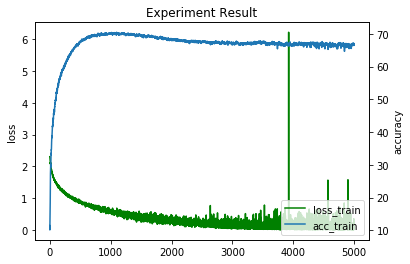

In [32]:
fig,ax1=plt.subplots()
ax2=ax1.twinx()
line1=ax1.plot(np.array(loss_train),color='g',label='loss_train')
line2=ax2.plot([i*1 for i in range(len(acc_train))],acc_train,label='acc_train')
lines=line1+line2
ax1.set_ylabel("loss")
ax2.set_ylabel("accuracy")
plt.xlabel('Epoch')
plt.title('Experiment Result')
plt.legend(lines,['loss_train','acc_train'])
plt.show()

cifar10 FedAvg Non-iid로 학습


In [33]:
device=torch.device('cuda')
FedAvg_model=Net().cuda()
criterion= nn.CrossEntropyLoss().to(device)
FedAvg_model.train()
epoch_loss = []

# Set optimizer for the local updates

optimizer = torch.optim.SGD(FedAvg_model.parameters(), lr=0.001,
                                momentum=0.9)
global_epoch=501

In [34]:
weight_saved=FedAvg_model.state_dict()

In [35]:
C=0.1
num_clients=100
CIFAR_noniid_dataset=cifar_noniid(trainset, num_clients,class_per_user=2)
#CIFAR_iid_dataset=cifar_iid(trainset, num_clients)
loss_train = []
acc_train=[]

In [36]:
#low boundary 안에 있는 녀석들만 update했을 때
learning_rate=0.0007
for epoch in range(global_epoch):

    #m=max(int(C*num_clients),1)
    m=5
    print(f"This is global {epoch} epoch")
    selected_user=np.random.choice(range(num_clients),m,replace=False)
    first=1
    local_setting=[]
    for repeat in range(10):
        local_gradient=[]
        local_loss=[]
        local_cut=[]
        
        for idx,user in enumerate(selected_user):
            #print(f"client :{idx}")
            if first==1:
                #local_setting.append(LocalUpdate(lr=0.0007,local_epoch=50,device=device,batch_size=40,dataset=trainset, idxs=CIFAR_iid_dataset[user]))
                local_setting.append(LocalUpdate(lr=learning_rate,local_epoch=local_epoch,device=device,batch_size=40,dataset=trainset, idxs=CIFAR_noniid_dataset[user]))
                this_local_setting=local_setting[-1]
            else:
                this_local_setting=local_setting[idx]
            gradient,loss,cut=this_local_setting.train(net=copy.deepcopy(FedAvg_model).to(device),On=False)

            local_gradient.append(copy.deepcopy(gradient))
            #print(local_weight[0].keys())
            local_loss.append(copy.deepcopy(loss))
            local_cut.append(copy.deepcopy(cut))
        #print("Local_gradient")
        #print(local_gradient)
        first=0
        FedAvg_gradient=copy.deepcopy(local_gradient[0])
        for i in range(len(FedAvg_gradient)):
            FedAvg_gradient[i]*=local_cut[0]
        #print(local_gradient)
        #for key in FedAvg_weight.keys():
        for i in range(1,len(local_gradient)):
            FedAvg_gradient=list_add(FedAvg_gradient,local_gradient[i],local_cut[i])
            #print(i)
            #print(FedAvg_gradient[0])
        #print("FedAvg_gradient")
        #print(FedAvg_gradient)
        temp=FedAvg_model.state_dict()
        for idx,key in enumerate(temp.keys()):
            #print(key)
            #print(temp[key].size())
            #print(FedAvg_gradient[idx].size())
            #print(torch.sign(FedAvg_gradient[idx]))
            #print(torch.sign(FedAvg_gradient[idx])*learning_rate)
            temp[key]+=-learning_rate*torch.sign(FedAvg_gradient[idx])
            #print(temp[key])
        FedAvg_model.load_state_dict(temp)
    first=1
    loss_avg = sum(local_loss) / len(local_loss)
    print(' Average loss {:.3f}'.format( loss_avg))
    loss_train.append(loss_avg)
    if epoch%1==0:
        for j in range(1):
            FedAvg_model.eval()         
            correct = 0
            total = 0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data[0].to(device), data[1].to(device)
                    outputs = FedAvg_model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %f %%' % (
                100 * correct / float(total)))
        acc_train.append(100 * correct / float(total))
 
    FedAvg_model.train()

This is global 0 epoch
0
0


/home/dana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 1.361
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 1.285
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 1.266
Accuracy of the network on the 10000 test images: 12.320000 %
This is global 3 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 1.138
Accuracy of the network on the 10000 test images: 9.990000 %
This is global 4 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.938
Accuracy of the network on the 10000 test images: 11.260000 %
Thi

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.597
Accuracy of the network on the 10000 test images: 32.310000 %
This is global 41 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.566
Accuracy of the network on the 10000 test images: 31.500000 %
This is global 42 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.730
Accuracy of the network on the 10000 test images: 31.300000 %
This is global 43 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.610
Accuracy of the network on the 10000 test images: 32.600000 %
This is global 44 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.634
Accuracy of the network on the 10000 test images: 14.350000 

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.313
Accuracy of the network on the 10000 test images: 45.820000 %
This is global 81 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.220
Accuracy of the network on the 10000 test images: 43.820000 %
This is global 82 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.291
Accuracy of the network on the 10000 test images: 36.270000 %
This is global 83 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.533
Accuracy of the network on the 10000 test images: 44.310000 %
This is global 84 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.518
Accuracy of the network on the 10000 test images: 37.720000 

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.449
Accuracy of the network on the 10000 test images: 41.510000 %
This is global 121 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.436
Accuracy of the network on the 10000 test images: 38.630000 %
This is global 122 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.385
Accuracy of the network on the 10000 test images: 44.400000 %
This is global 123 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.189
Accuracy of the network on the 10000 test images: 47.270000 %
This is global 124 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.256
Accuracy of the network on the 10000 test images: 41.9

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.261
Accuracy of the network on the 10000 test images: 48.630000 %
This is global 161 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.378
Accuracy of the network on the 10000 test images: 50.250000 %
This is global 162 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.203
Accuracy of the network on the 10000 test images: 45.960000 %
This is global 163 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.263
Accuracy of the network on the 10000 test images: 50.210000 %
This is global 164 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.226
Accuracy of the network on the 10000 test images: 51.3

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.102
Accuracy of the network on the 10000 test images: 53.140000 %
This is global 201 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.332
Accuracy of the network on the 10000 test images: 54.150000 %
This is global 202 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.346
Accuracy of the network on the 10000 test images: 46.250000 %
This is global 203 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.146
Accuracy of the network on the 10000 test images: 52.170000 %
This is global 204 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.366
Accuracy of the network on the 10000 test images: 47.860

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.281
Accuracy of the network on the 10000 test images: 52.600000 %
This is global 241 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.290
Accuracy of the network on the 10000 test images: 47.160000 %
This is global 242 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.240
Accuracy of the network on the 10000 test images: 51.830000 %
This is global 243 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.093
Accuracy of the network on the 10000 test images: 55.840000 %
This is global 244 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.227
Accuracy of the network on the 10000 test images: 50.9

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.280
Accuracy of the network on the 10000 test images: 47.420000 %
This is global 281 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.148
Accuracy of the network on the 10000 test images: 43.990000 %
This is global 282 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.170
Accuracy of the network on the 10000 test images: 52.870000 %
This is global 283 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.084
Accuracy of the network on the 10000 test images: 52.940000 %
This is global 284 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.093
Accuracy of the network on the 10000 test images: 51.1

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.126
Accuracy of the network on the 10000 test images: 54.270000 %
This is global 321 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.069
Accuracy of the network on the 10000 test images: 54.650000 %
This is global 322 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.173
Accuracy of the network on the 10000 test images: 53.230000 %
This is global 323 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.059
Accuracy of the network on the 10000 test images: 52.450000 %
This is global 324 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.129
Accuracy of the network on the 10000 test images: 52.8

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.107
Accuracy of the network on the 10000 test images: 50.200000 %
This is global 361 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.078
Accuracy of the network on the 10000 test images: 38.050000 %
This is global 362 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.143
Accuracy of the network on the 10000 test images: 51.970000 %
This is global 363 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.143
Accuracy of the network on the 10000 test images: 54.910000 %
This is global 364 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.107
Accuracy of the network on the 10000 test images: 50.120

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.148
Accuracy of the network on the 10000 test images: 55.550000 %
This is global 401 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.100
Accuracy of the network on the 10000 test images: 49.960000 %
This is global 402 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.061
Accuracy of the network on the 10000 test images: 53.940000 %
This is global 403 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.065
Accuracy of the network on the 10000 test images: 57.560000 %
This is global 404 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.183
Accuracy of the network on the 10000 test images: 54.410

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.047
Accuracy of the network on the 10000 test images: 55.490000 %
This is global 441 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.531
Accuracy of the network on the 10000 test images: 54.240000 %
This is global 442 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.066
Accuracy of the network on the 10000 test images: 53.340000 %
This is global 443 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.065
Accuracy of the network on the 10000 test images: 53.880000 %
This is global 444 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.092
Accuracy of the network on the 10000 test images: 46.4

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.055
Accuracy of the network on the 10000 test images: 55.810000 %
This is global 481 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.068
Accuracy of the network on the 10000 test images: 55.680000 %
This is global 482 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.061
Accuracy of the network on the 10000 test images: 54.120000 %
This is global 483 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.035
Accuracy of the network on the 10000 test images: 51.910000 %
This is global 484 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.100
Accuracy of the network on the 10000 test images: 54.0

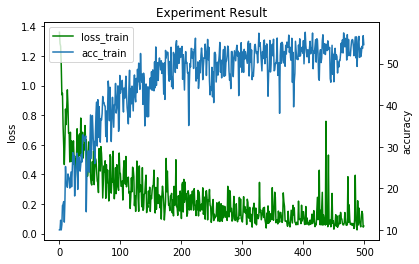

In [37]:
fig,ax1=plt.subplots()
ax2=ax1.twinx()
line1=ax1.plot(np.array(loss_train[:500]),color='g',label='loss_train')
line2=ax2.plot([i*1 for i in range(len(acc_train[:500]))],acc_train[:500],label='acc_train')
lines=line1+line2
ax1.set_ylabel("loss")
ax2.set_ylabel("accuracy")
plt.xlabel('Epoch')
plt.title('Experiment Result')
plt.legend(lines,['loss_train','acc_train'])
plt.show()

In [38]:
device=torch.device('cuda')
FedAvg_model=Net().cuda()
criterion= nn.CrossEntropyLoss().to(device)
FedAvg_model.train()
epoch_loss = []

# Set optimizer for the local updates

optimizer = torch.optim.SGD(FedAvg_model.parameters(), lr=0.001,
                                momentum=0.9)
global_epoch=2001

In [39]:
C=0.1
num_clients=100
CIFAR_noniid_dataset=cifar_noniid(trainset, num_clients)
#CIFAR_iid_dataset=cifar_iid(trainset, num_clients)
loss_train = []
acc_train=[]

In [40]:
#low boundary 안에 있는 녀석들만 update했을 때
learning_rate=0.0007
for epoch in range(global_epoch):

    #m=max(int(C*num_clients),1)
    m=5
    print(f"This is global {epoch} epoch")
    selected_user=np.random.choice(range(num_clients),m,replace=False)
    first=1
    local_setting=[]
    for repeat in range(10):
        local_gradient=[]
        local_loss=[]
        local_cut=[]
        
        for idx,user in enumerate(selected_user):
            #print(f"client :{idx}")
            if first==1:
                #local_setting.append(LocalUpdate(lr=0.0007,local_epoch=50,device=device,batch_size=40,dataset=trainset, idxs=CIFAR_iid_dataset[user]))
                local_setting.append(LocalUpdate(lr=learning_rate,local_epoch=local_epoch,device=device,batch_size=40,dataset=trainset, idxs=CIFAR_noniid_dataset[user]))
                this_local_setting=local_setting[-1]
            else:
                this_local_setting=local_setting[idx]
            gradient,loss,cut=this_local_setting.train(net=copy.deepcopy(FedAvg_model).to(device),On=False)

            local_gradient.append(copy.deepcopy(gradient))
            #print(local_weight[0].keys())
            local_loss.append(copy.deepcopy(loss))
            local_cut.append(copy.deepcopy(cut))
        #print("Local_gradient")
        #print(local_gradient)
        first=0
        FedAvg_gradient=copy.deepcopy(local_gradient[0])
        for i in range(len(FedAvg_gradient)):
            FedAvg_gradient[i]*=local_cut[0]
        #print(local_gradient)
        #for key in FedAvg_weight.keys():
        for i in range(1,len(local_gradient)):
            FedAvg_gradient=list_add(FedAvg_gradient,local_gradient[i],local_cut[i])
            #print(i)
            #print(FedAvg_gradient[0])
        #print("FedAvg_gradient")
        #print(FedAvg_gradient)
        temp=FedAvg_model.state_dict()
        for idx,key in enumerate(temp.keys()):
            #print(key)
            #print(temp[key].size())
            #print(FedAvg_gradient[idx].size())
            #print(torch.sign(FedAvg_gradient[idx]))
            #print(torch.sign(FedAvg_gradient[idx])*learning_rate)
            temp[key]+=-learning_rate*torch.sign(FedAvg_gradient[idx])
            #print(temp[key])
        FedAvg_model.load_state_dict(temp)
    first=1
    loss_avg = sum(local_loss) / len(local_loss)
    print(' Average loss {:.3f}'.format( loss_avg))
    loss_train.append(loss_avg)
    if epoch%1==0:
        for j in range(1):
            FedAvg_model.eval()         
            correct = 0
            total = 0
            with torch.no_grad():
                for data in testloader:
                    images, labels = data[0].to(device), data[1].to(device)
                    outputs = FedAvg_model(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

            print('Accuracy of the network on the 10000 test images: %f %%' % (
                100 * correct / float(total)))
        acc_train.append(100 * correct / float(total))
 
    FedAvg_model.train()

This is global 0 epoch
0
0


/home/dana/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.103
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.118
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 2 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.160
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 3 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.139
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 4 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.145
Accuracy of the network on the 10000 test images: 10.000000 %
Th

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.160
Accuracy of the network on the 10000 test images: 10.190000 %
This is global 41 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.174
Accuracy of the network on the 10000 test images: 10.010000 %
This is global 42 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.154
Accuracy of the network on the 10000 test images: 9.880000 %
This is global 43 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.177
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 44 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.147
Accuracy of the network on the 10000 test images: 10.610000

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.158
Accuracy of the network on the 10000 test images: 9.840000 %
This is global 81 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.178
Accuracy of the network on the 10000 test images: 9.960000 %
This is global 82 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.180
Accuracy of the network on the 10000 test images: 9.790000 %
This is global 83 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.157
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 84 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.162
Accuracy of the network on the 10000 test images: 10.000000 %
T

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.173
Accuracy of the network on the 10000 test images: 9.750000 %
This is global 121 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.183
Accuracy of the network on the 10000 test images: 10.140000 %
This is global 122 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.192
Accuracy of the network on the 10000 test images: 10.040000 %
This is global 123 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.200
Accuracy of the network on the 10000 test images: 12.050000 %
This is global 124 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.198
Accuracy of the network on the 10000 test images: 7.62000

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.170
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 161 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.188
Accuracy of the network on the 10000 test images: 9.590000 %
This is global 162 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.125
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 163 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.230
Accuracy of the network on the 10000 test images: 10.350000 %
This is global 164 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.199
Accuracy of the network on the 10000 test images: 8.84000

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.195
Accuracy of the network on the 10000 test images: 10.680000 %
This is global 201 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.241
Accuracy of the network on the 10000 test images: 10.480000 %
This is global 202 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.160
Accuracy of the network on the 10000 test images: 10.240000 %
This is global 203 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.219
Accuracy of the network on the 10000 test images: 9.950000 %
This is global 204 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.137
Accuracy of the network on the 10000 test images: 10.1800

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.289
Accuracy of the network on the 10000 test images: 10.050000 %
This is global 241 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.203
Accuracy of the network on the 10000 test images: 9.970000 %
This is global 242 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.223
Accuracy of the network on the 10000 test images: 10.370000 %
This is global 243 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.283
Accuracy of the network on the 10000 test images: 10.230000 %
This is global 244 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.341
Accuracy of the network on the 10000 test images: 10.3700

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.248
Accuracy of the network on the 10000 test images: 10.500000 %
This is global 281 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.256
Accuracy of the network on the 10000 test images: 10.310000 %
This is global 282 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.195
Accuracy of the network on the 10000 test images: 11.070000 %
This is global 283 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.240
Accuracy of the network on the 10000 test images: 10.450000 %
This is global 284 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.162
Accuracy of the network on the 10000 test images: 10.400

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.429
Accuracy of the network on the 10000 test images: 10.320000 %
This is global 321 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.214
Accuracy of the network on the 10000 test images: 10.090000 %
This is global 322 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.238
Accuracy of the network on the 10000 test images: 10.120000 %
This is global 323 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.189
Accuracy of the network on the 10000 test images: 10.280000 %
This is global 324 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.226
Accuracy of the network on the 10000 test images: 10.010

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.200
Accuracy of the network on the 10000 test images: 10.480000 %
This is global 361 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.209
Accuracy of the network on the 10000 test images: 10.740000 %
This is global 362 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.201
Accuracy of the network on the 10000 test images: 10.300000 %
This is global 363 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.174
Accuracy of the network on the 10000 test images: 8.190000 %
This is global 364 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.261
Accuracy of the network on the 10000 test images: 10.1600

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.222
Accuracy of the network on the 10000 test images: 10.100000 %
This is global 401 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.206
Accuracy of the network on the 10000 test images: 10.510000 %
This is global 402 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.228
Accuracy of the network on the 10000 test images: 10.570000 %
This is global 403 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.195
Accuracy of the network on the 10000 test images: 10.700000 %
This is global 404 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.233
Accuracy of the network on the 10000 test images: 10.7

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.216
Accuracy of the network on the 10000 test images: 10.240000 %
This is global 441 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.148
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 442 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.220
Accuracy of the network on the 10000 test images: 10.200000 %
This is global 443 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.196
Accuracy of the network on the 10000 test images: 10.260000 %
This is global 444 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.191
Accuracy of the network on the 10000 test images: 10.7

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.171
Accuracy of the network on the 10000 test images: 10.920000 %
This is global 481 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.191
Accuracy of the network on the 10000 test images: 10.110000 %
This is global 482 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.167
Accuracy of the network on the 10000 test images: 10.180000 %
This is global 483 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.232
Accuracy of the network on the 10000 test images: 10.730000 %
This is global 484 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.218
Accuracy of the network on the 10000 test images: 10.370

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.199
Accuracy of the network on the 10000 test images: 9.730000 %
This is global 521 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.180
Accuracy of the network on the 10000 test images: 7.430000 %
This is global 522 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.209
Accuracy of the network on the 10000 test images: 10.160000 %
This is global 523 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.180
Accuracy of the network on the 10000 test images: 10.210000 %
This is global 524 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.187
Accuracy of the network on the 10000 test images: 10.71000

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.205
Accuracy of the network on the 10000 test images: 10.400000 %
This is global 561 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.216
Accuracy of the network on the 10000 test images: 10.650000 %
This is global 562 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.225
Accuracy of the network on the 10000 test images: 10.420000 %
This is global 563 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.203
Accuracy of the network on the 10000 test images: 10.090000 %
This is global 564 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.219
Accuracy of the network on the 10000 test images: 10.4

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.170
Accuracy of the network on the 10000 test images: 10.380000 %
This is global 601 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.184
Accuracy of the network on the 10000 test images: 10.150000 %
This is global 602 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.172
Accuracy of the network on the 10000 test images: 10.490000 %
This is global 603 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.192
Accuracy of the network on the 10000 test images: 10.120000 %
This is global 604 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.158
Accuracy of the network on the 10000 test images: 10.420

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.180
Accuracy of the network on the 10000 test images: 9.660000 %
This is global 641 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.190
Accuracy of the network on the 10000 test images: 10.190000 %
This is global 642 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.171
Accuracy of the network on the 10000 test images: 10.230000 %
This is global 643 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.198
Accuracy of the network on the 10000 test images: 10.150000 %
This is global 644 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.175
Accuracy of the network on the 10000 test images: 12.81

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.201
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 681 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.215
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 682 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.182
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 683 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.203
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 684 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.196
Accuracy of the network on the 10000 test images: 10.000

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.168
Accuracy of the network on the 10000 test images: 10.690000 %
This is global 721 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.205
Accuracy of the network on the 10000 test images: 10.440000 %
This is global 722 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.219
Accuracy of the network on the 10000 test images: 10.300000 %
This is global 723 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.205
Accuracy of the network on the 10000 test images: 10.450000 %
This is global 724 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.190
Accuracy of the network on the 10000 test images: 11.020

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.209
Accuracy of the network on the 10000 test images: 10.270000 %
This is global 761 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.205
Accuracy of the network on the 10000 test images: 10.250000 %
This is global 762 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.182
Accuracy of the network on the 10000 test images: 10.220000 %
This is global 763 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.223
Accuracy of the network on the 10000 test images: 10.410000 %
This is global 764 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.136
Accuracy of the network on the 10000 test images: 10.0

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.310
Accuracy of the network on the 10000 test images: 10.250000 %
This is global 801 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.194
Accuracy of the network on the 10000 test images: 10.980000 %
This is global 802 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.463
Accuracy of the network on the 10000 test images: 10.690000 %
This is global 803 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.192
Accuracy of the network on the 10000 test images: 10.440000 %
This is global 804 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.197
Accuracy of the network on the 10000 test images: 10.260

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.195
Accuracy of the network on the 10000 test images: 10.720000 %
This is global 841 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.269
Accuracy of the network on the 10000 test images: 10.400000 %
This is global 842 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.211
Accuracy of the network on the 10000 test images: 10.640000 %
This is global 843 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.398
Accuracy of the network on the 10000 test images: 10.940000 %
This is global 844 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.183
Accuracy of the network on the 10000 test images: 10.110

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.173
Accuracy of the network on the 10000 test images: 11.140000 %
This is global 881 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.172
Accuracy of the network on the 10000 test images: 10.310000 %
This is global 882 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.184
Accuracy of the network on the 10000 test images: 10.330000 %
This is global 883 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.171
Accuracy of the network on the 10000 test images: 10.450000 %
This is global 884 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.409
Accuracy of the network on the 10000 test images: 10.180

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.204
Accuracy of the network on the 10000 test images: 10.020000 %
This is global 921 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.218
Accuracy of the network on the 10000 test images: 10.080000 %
This is global 922 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.142
Accuracy of the network on the 10000 test images: 10.010000 %
This is global 923 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.275
Accuracy of the network on the 10000 test images: 10.120000 %
This is global 924 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.191
Accuracy of the network on the 10000 test images: 10.130

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.172
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 961 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.187
Accuracy of the network on the 10000 test images: 10.110000 %
This is global 962 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.199
Accuracy of the network on the 10000 test images: 10.010000 %
This is global 963 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.193
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 964 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.204
Accuracy of the network on the 10000 test images: 10.010

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.191
Accuracy of the network on the 10000 test images: 13.600000 %
This is global 1001 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.175
Accuracy of the network on the 10000 test images: 11.050000 %
This is global 1002 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.182
Accuracy of the network on the 10000 test images: 10.930000 %
This is global 1003 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.183
Accuracy of the network on the 10000 test images: 10.580000 %
This is global 1004 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.151
Accuracy of the network on the 10000 test images: 10

0
0
0
0
0
0
 Average loss 0.169
Accuracy of the network on the 10000 test images: 9.720000 %
This is global 1040 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.173
Accuracy of the network on the 10000 test images: 10.040000 %
This is global 1041 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.144
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1042 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.243
Accuracy of the network on the 10000 test images: 10.040000 %
This is global 1043 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.145
Accuracy of the network on the 10000 test images: 10.020000 %
This is global 1044 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.270
Accuracy of the network on the 10000 test images: 10.010000 %
This is global 1080 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.278
Accuracy of the network on the 10000 test images: 10.050000 %
This is global 1081 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.170
Accuracy of the network on the 10000 test images: 13.780000 %
This is global 1082 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.187
Accuracy of the network on the 10000 test images: 11.260000 %
This is global 1083 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.193
Accuracy of the network on the 10000 test images: 

0
0
0
0
0
0
 Average loss 0.164
Accuracy of the network on the 10000 test images: 10.060000 %
This is global 1119 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.170
Accuracy of the network on the 10000 test images: 10.180000 %
This is global 1120 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.235
Accuracy of the network on the 10000 test images: 10.080000 %
This is global 1121 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.183
Accuracy of the network on the 10000 test images: 10.040000 %
This is global 1122 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.228
Accuracy of the network on the 10000 test images: 10.130000 %
This is global 1123 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.180
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1159 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.184
Accuracy of the network on the 10000 test images: 10.000000 %
This is global 1160 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.187
Accuracy of the network on the 10000 test images: 11.060000 %
This is global 1161 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.181
Accuracy of the network on the 10000 test images: 10.130000 %
This is global 1162 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.165
Accuracy of the network on the 10000 test images: 10

0
0
0
0
0
0
 Average loss 0.206
Accuracy of the network on the 10000 test images: 10.110000 %
This is global 1198 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.122
Accuracy of the network on the 10000 test images: 12.000000 %
This is global 1199 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.195
Accuracy of the network on the 10000 test images: 10.130000 %
This is global 1200 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.174
Accuracy of the network on the 10000 test images: 10.090000 %
This is global 1201 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.186
Accuracy of the network on the 10000 test images: 10.140000 %
This is global 1202 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.205
Accuracy of the network on the 10000 test images: 10.140000 %
This is global 1238 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.181
Accuracy of the network on the 10000 test images: 10.040000 %
This is global 1239 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.180
Accuracy of the network on the 10000 test images: 10.050000 %
This is global 1240 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.191
Accuracy of the network on the 10000 test images: 10.070000 %
This is global 1241 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.214
Accuracy of the network on the 10000 test images: 10

0
0
0
0
0
0
 Average loss 0.228
Accuracy of the network on the 10000 test images: 10.040000 %
This is global 1277 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.218
Accuracy of the network on the 10000 test images: 10.040000 %
This is global 1278 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.194
Accuracy of the network on the 10000 test images: 11.220000 %
This is global 1279 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.195
Accuracy of the network on the 10000 test images: 10.040000 %
This is global 1280 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.202
Accuracy of the network on the 10000 test images: 10.040000 %
This is global 1281 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.190
Accuracy of the network on the 10000 test images: 10.040000 %
This is global 1317 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.165
Accuracy of the network on the 10000 test images: 8.450000 %
This is global 1318 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.290
Accuracy of the network on the 10000 test images: 10.070000 %
This is global 1319 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.446
Accuracy of the network on the 10000 test images: 10.060000 %
This is global 1320 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.188
Accuracy of the network on the 10000 test images: 10.

0
0
0
0
 Average loss 0.549
Accuracy of the network on the 10000 test images: 10.150000 %
This is global 1356 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.171
Accuracy of the network on the 10000 test images: 10.140000 %
This is global 1357 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.175
Accuracy of the network on the 10000 test images: 9.980000 %
This is global 1358 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.178
Accuracy of the network on the 10000 test images: 10.750000 %
This is global 1359 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.427
Accuracy of the network on the 10000 test images: 10.250000 %
This is global 1360 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.189
Accuracy of the network on the 10000 test images: 10.100000 %
This is global 1396 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.188
Accuracy of the network on the 10000 test images: 10.040000 %
This is global 1397 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.189
Accuracy of the network on the 10000 test images: 10.050000 %
This is global 1398 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.154
Accuracy of the network on the 10000 test images: 10.070000 %
This is global 1399 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.193
Accuracy of the network on the 10000 test images: 10

0
0
0
0
0
0
 Average loss 0.578
Accuracy of the network on the 10000 test images: 10.460000 %
This is global 1435 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.239
Accuracy of the network on the 10000 test images: 10.410000 %
This is global 1436 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.275
Accuracy of the network on the 10000 test images: 10.350000 %
This is global 1437 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.200
Accuracy of the network on the 10000 test images: 10.130000 %
This is global 1438 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.204
Accuracy of the network on the 10000 test images: 10.110000 %
This is global 1439 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.209
Accuracy of the network on the 10000 test images: 10.480000 %
This is global 1475 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.230
Accuracy of the network on the 10000 test images: 10.050000 %
This is global 1476 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.163
Accuracy of the network on the 10000 test images: 10.410000 %
This is global 1477 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.197
Accuracy of the network on the 10000 test images: 10.210000 %
This is global 1478 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.176
Accuracy of the network on the 10000 test images: 10

0
0
0
0
0
0
 Average loss 0.225
Accuracy of the network on the 10000 test images: 10.130000 %
This is global 1514 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.282
Accuracy of the network on the 10000 test images: 10.160000 %
This is global 1515 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.209
Accuracy of the network on the 10000 test images: 10.100000 %
This is global 1516 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.197
Accuracy of the network on the 10000 test images: 10.230000 %
This is global 1517 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.179
Accuracy of the network on the 10000 test images: 10.080000 %
This is global 1518 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.346
Accuracy of the network on the 10000 test images: 10.640000 %
This is global 1554 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.151
Accuracy of the network on the 10000 test images: 10.080000 %
This is global 1555 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.358
Accuracy of the network on the 10000 test images: 10.580000 %
This is global 1556 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.226
Accuracy of the network on the 10000 test images: 10.230000 %
This is global 1557 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.207
Accuracy of the network on the 10000 test images: 10

0
0
0
0
0
0
 Average loss 0.234
Accuracy of the network on the 10000 test images: 12.870000 %
This is global 1593 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.179
Accuracy of the network on the 10000 test images: 11.430000 %
This is global 1594 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.258
Accuracy of the network on the 10000 test images: 13.940000 %
This is global 1595 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.212
Accuracy of the network on the 10000 test images: 10.970000 %
This is global 1596 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.211
Accuracy of the network on the 10000 test images: 10.190000 %
This is global 1597 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.218
Accuracy of the network on the 10000 test images: 12.680000 %
This is global 1633 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.174
Accuracy of the network on the 10000 test images: 13.080000 %
This is global 1634 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.187
Accuracy of the network on the 10000 test images: 10.510000 %
This is global 1635 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.172
Accuracy of the network on the 10000 test images: 10.160000 %
This is global 1636 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.232
Accuracy of the network on the 10000 test images: 10

0
0
0
0
0
0
 Average loss 0.161
Accuracy of the network on the 10000 test images: 10.900000 %
This is global 1672 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.142
Accuracy of the network on the 10000 test images: 10.840000 %
This is global 1673 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.146
Accuracy of the network on the 10000 test images: 10.670000 %
This is global 1674 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.300
Accuracy of the network on the 10000 test images: 10.240000 %
This is global 1675 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.174
Accuracy of the network on the 10000 test images: 10.340000 %
This is global 1676 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.236
Accuracy of the network on the 10000 test images: 10.570000 %
This is global 1712 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.935
Accuracy of the network on the 10000 test images: 10.180000 %
This is global 1713 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.220
Accuracy of the network on the 10000 test images: 10.500000 %
This is global 1714 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.259
Accuracy of the network on the 10000 test images: 10.270000 %
This is global 1715 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.228
Accuracy of the network on the 10000 test images: 11

0
0
0
0
0
0
 Average loss 0.249
Accuracy of the network on the 10000 test images: 10.060000 %
This is global 1751 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.198
Accuracy of the network on the 10000 test images: 10.140000 %
This is global 1752 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.200
Accuracy of the network on the 10000 test images: 10.060000 %
This is global 1753 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.232
Accuracy of the network on the 10000 test images: 10.170000 %
This is global 1754 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.187
Accuracy of the network on the 10000 test images: 10.040000 %
This is global 1755 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.270
Accuracy of the network on the 10000 test images: 10.190000 %
This is global 1791 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.203
Accuracy of the network on the 10000 test images: 10.200000 %
This is global 1792 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.270
Accuracy of the network on the 10000 test images: 10.120000 %
This is global 1793 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.195
Accuracy of the network on the 10000 test images: 10.660000 %
This is global 1794 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.200
Accuracy of the network on the 10000 test images: 10

0
0
0
0
0
0
 Average loss 0.158
Accuracy of the network on the 10000 test images: 10.060000 %
This is global 1830 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.236
Accuracy of the network on the 10000 test images: 10.430000 %
This is global 1831 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.273
Accuracy of the network on the 10000 test images: 10.320000 %
This is global 1832 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.194
Accuracy of the network on the 10000 test images: 12.740000 %
This is global 1833 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.205
Accuracy of the network on the 10000 test images: 10.280000 %
This is global 1834 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.181
Accuracy of the network on the 10000 test images: 11.220000 %
This is global 1870 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.188
Accuracy of the network on the 10000 test images: 11.260000 %
This is global 1871 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.228
Accuracy of the network on the 10000 test images: 10.740000 %
This is global 1872 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.244
Accuracy of the network on the 10000 test images: 10.540000 %
This is global 1873 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 1.064
Accuracy of the network on the 10000 test images: 10

0
0
0
0
0
0
 Average loss 0.172
Accuracy of the network on the 10000 test images: 10.290000 %
This is global 1909 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.244
Accuracy of the network on the 10000 test images: 10.290000 %
This is global 1910 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.210
Accuracy of the network on the 10000 test images: 9.460000 %
This is global 1911 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.232
Accuracy of the network on the 10000 test images: 10.130000 %
This is global 1912 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.248
Accuracy of the network on the 10000 test images: 10.080000 %
This is global 1913 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.666
Accuracy of the network on the 10000 test images: 10.490000 %
This is global 1949 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.256
Accuracy of the network on the 10000 test images: 10.140000 %
This is global 1950 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.167
Accuracy of the network on the 10000 test images: 10.050000 %
This is global 1951 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.211
Accuracy of the network on the 10000 test images: 10.240000 %
This is global 1952 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.263
Accuracy of the network on the 10000 test images: 10

0
0
0
0
0
 Average loss 0.249
Accuracy of the network on the 10000 test images: 10.010000 %
This is global 1988 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.181
Accuracy of the network on the 10000 test images: 10.260000 %
This is global 1989 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.278
Accuracy of the network on the 10000 test images: 10.270000 %
This is global 1990 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 1.100
Accuracy of the network on the 10000 test images: 10.140000 %
This is global 1991 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
 Average loss 0.162
Accuracy of the network on the 10000 test images: 10.060000 %
This is global 1992 epoch
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


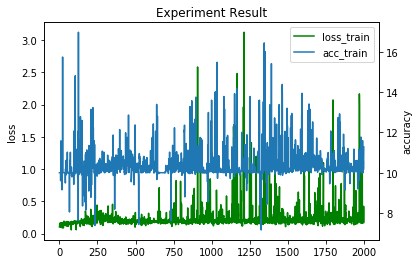

In [41]:
fig,ax1=plt.subplots()
ax2=ax1.twinx()
line1=ax1.plot(np.array(loss_train),color='g',label='loss_train')
line2=ax2.plot([i*1 for i in range(len(acc_train))],acc_train,label='acc_train')
lines=line1+line2
ax1.set_ylabel("loss")
ax2.set_ylabel("accuracy")
plt.xlabel('Epoch')
plt.title('Experiment Result')
plt.legend(lines,['loss_train','acc_train'])
plt.show()